Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [1]:
NAME = "Bishal Khanal"
ID = "st122221"

---

# Lab 07: Support Vector Machines

Today we'll look at the SVM maximum margin classification problem and how we can implement the optimization
in Python.

We'll use the cvxopt quadratic programming optimizer in Python.

Later in the lectures, we'll see that more specialized algorithms such as Sequential Minimal Optimization
implemented by the machine learning libraries are more effective for large SVM problems.

## Linearly separable case: Direct solution using quadratic programming

If we assume that the data are linearly separable, we can use the following setup for the optimization:
- The data are pairs $(\mathbf{x}^{(i)},y^{(i)})$ with $\mathbf{x}^{(i)} \in \mathbb{R}^n$ and $y^{(i)} \in \{-1,1\}$.
- The hypothesis is
  $$h_{\mathbf{w},b}(\mathbf{x}) = \begin{cases} 1 & \text{if} \; \mathbf{w}^\top \mathbf{x} + b > 0 \\ -1 & \text{otherwise} \end{cases}$$
- The objective function is
  $$\mathbf{w}^*,b^* = \mathrm{argmax}_{\mathbf{w},b} \gamma,$$
  where $\gamma$ is the minimum geometric margin for the training data:
  $$\gamma = \min_i \gamma^{(i)}$$
  and $\gamma^{(i)}$ is the geometric margin for training example $i$, i.e., the signed distance of $\mathbf{x}^{(i)}$ from the decision boundary,
  with positive distances indicating that the point is on the correct side of the boundary and negative distances indicating that the point is on the
  incorrect side of the boundary:
  $$\gamma^{(i)} = y^{(i)}\left( \left( \frac{\mathbf{w}}{\|\mathbf{w}\|} \right)^\top \mathbf{x}^{(i)} + \frac{b}{\| \mathbf{w}\|} \right). $$
- As we derived in lecture, to find the optimal $\mathbf{w},b$ according to the objective function above, we can in its place solve the constrained
  optimization problem
  $$ \begin{array}{rl} \min_{\mathbf{w},b} & \frac{1}{2}\|\mathbf{w}\|^2 \\
                     \text{subject to} & y^{(i)}(\mathbf{w}^\top\mathbf{x}^{(i)}+b)\ge 1, i \in 1..m
   \end{array}
  $$
  
So let's do it! In case you don't already have the cvxopt pip package installed:

In [2]:
# Run in case there is no cvxopt installed. You can also do this in a separate terminal.

!https_proxy=http://192.41.170.23:3128 http_proxy=http://192.41.170.23:3128 pip install cvxopt

     |████████████████████████████████| 13.0 MB 10.5 MB/s eta 0:00:01


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cvxopt

Here are some sample data. In this example, we've planted some specific points that will serve as the support vectors so that we know the "correct" answer for the maximum margin hyperplane.

In [4]:
Xf = np.matrix([[ 164.939, 163.431, 157.554, 152.785, 156.385, 159.242, 156.281, 164.411, 157.308, 159.579 ],
                [  56.927,  48.945,  45.678,  45.969,  40.896,  46.848,  42.225,  42.380,  42.150,  49.739 ]]).T;
Xm = np.matrix([[ 168.524, 171.597, 179.469, 176.063, 180.939, 177.011, 183.284, 180.549, 176.502, 185.392 ],
                [  64.353,  61.793,  74.552,  69.851,  74.730,  75.871,  79.170,  79.753,  64.923,  73.665 ]]).T;
X = np.concatenate([Xf, Xm],0);
y = np.concatenate([-np.matrix(np.ones([10,1])),np.matrix(np.ones([10,1]))]);

In [5]:
print(X.shape)
print(y.shape)

(20, 2)
(20, 1)


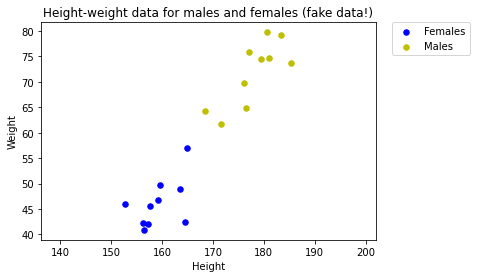

In [6]:
# Plot the data
def plot_mf(Xf,Xm):
    axes = plt.axes()
    females_series = plt.scatter(np.array(Xf[:,0]), np.array(Xf[:,1]), s=30, c='b', marker='o', label='Females')
    males_series = plt.scatter(np.array(Xm[:,0]), np.array(Xm[:,1]), s=30, c='y', marker='o', label='Males')
    axes.set_aspect('equal', 'datalim')
    plt.xlabel('Height')
    plt.ylabel('Weight')
    plt.title('Height-weight data for males and females (fake data!)')
    plt.legend(handles=[females_series, males_series], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    return axes

def plot_w(axes, w, b):
    ylim = axes.get_ylim()
    xlim = axes.get_xlim()
    p1 = (xlim[0], - (w[0,0] * xlim[0] + b) / w[1,0])
    p2 = (xlim[1], - (w[0,0] * xlim[1] + b) / w[1,0])
    plt.plot((p1[0],p2[0]), (p1[1],p2[1]), 'r-')
    
plot_mf(Xf, Xm)
plt.show()

## Exercise 1 (in lab): Linearly separable data (total of 25 points)

Take the example data and SVM optimization code using cvxopt from the exercise in lecture. Verify that you can find the decision boundary for such "easy" cases.
Show your results in your lab report. We'll go step by step below.

### Exercise 1.1 Create SVM function using cvopt (5 points)

You'll want to ensure that $\mathtt{Q}$ is symmetric by setting it to $(\mathtt{Q} + \mathtt{Q}^\top)/2$.
Then create an `args` variable containing $\mathtt{Q}$ and $\mathbf{c}$, each converted from numpy to
cvxopt using `cvxopt.matrix(numpy_matrix)`. If `A` is supplied, you should add `A` and `B` to the
list of arguments, and if `E` is supplied, you should add `E` and `d` to the list of arguments. Finally,
you can call `cvxopt.solvers.qp(*args)`. If the status returned is `optimal` return the valid solution else
return `None`.

In [7]:
def cvxopt_solve_qp(Q, c, A=None, B=None, E=None, d=None):
    # Fill your code value in 'None'
    # Some 'None' can be avoided.
    
#     Q_new = None
#     args = [None, None]
#     if A is not None:
#         args.extend([None, None])
#         if E is not None:
#             args.extend([None, None])
#     sol = None
#     if sol is not None and 'optimal' not in sol['status']:
#         return None
#     x = None

    # YOUR CODE HERE
    Q_new = (Q + Q.T)/2
    args = [cvxopt.matrix(Q_new), cvxopt.matrix(c)]
    if A is not None:
        args.extend([cvxopt.matrix(A), cvxopt.matrix(B)])
        if E is not None:
            args.extend([cvxopt.matrix(E), cvxopt.matrix(d)])
            
    sol = cvxopt.solvers.qp(*args)
    
    if sol is not None and 'optimal' not in sol['status']:
        return None
#     print(sol)
    x = sol['x']
    
    return x

In [8]:
# Test function: Do not remove
Q_test = np.array([[1, 0],[0, 0]])
c_test = np.zeros([2])
A_test = np.array([[15., 1.],[14., 1.], [13., 1], [-5.,-1.],[-6.,-1.],[-8,-1]])
B_test = -np.ones([6])
try:
    x_test = cvxopt_solve_qp(Q_test, c_test, A_test, B_test)
    print('x_test:', x_test)
except:
    assert False, "cvxopt_solve_qp is incorrect"

print("success!")
# End Test function

     pcost       dcost       gap    pres   dres
 0:  2.8800e-02  1.0464e+00  1e+01  1e+00  3e+01
 1:  1.8859e-01 -8.5852e-01  1e+00  2e-01  3e+00
 2:  1.6523e-01  3.7852e-02  1e-01  4e-16  4e-16
 3:  8.2300e-02  7.2465e-02  1e-02  6e-16  3e-15
 4:  8.0043e-02  7.9915e-02  1e-04  7e-16  2e-16
 5:  8.0000e-02  7.9999e-02  1e-06  2e-16  1e-15
 6:  8.0000e-02  8.0000e-02  1e-08  8e-16  1e-15
Optimal solution found.
x_test: [-4.00e-01]
[ 4.20e+00]

success!


**Expected result (or look-alike)**:\
     pcost       dcost       gap    pres   dres\
 0:  2.8800e-02  1.0464e+00  1e+01  1e+00  3e+01\
 1:  1.8859e-01 -8.5852e-01  1e+00  2e-01  3e+00\
 2:  1.6523e-01  3.7852e-02  1e-01  4e-16  4e-16\
 3:  8.2300e-02  7.2465e-02  1e-02  6e-16  3e-15\
 4:  8.0043e-02  7.9915e-02  1e-04  7e-16  2e-16\
 5:  8.0000e-02  7.9999e-02  1e-06  2e-16  1e-15\
 6:  8.0000e-02  8.0000e-02  1e-08  8e-16  1e-15\
Optimal solution found.\
x_test: [-0.40000001  4.20000012]\

### Exercise 1.2: Find Q, c, A, B for input into cvxopt_solve_qp function (10 points)

Now you should use the `cvxopt_solve_qp` function to find $\mathbf{w}$ and $b$ for the data $\mathtt{X}, \mathbf{y}$ prepared earlier. You'll need to set up numpy arrays for $\mathtt{Q}$, $\mathbf{c}$, $\mathtt{A}$, and $\mathtt{B}$ that when passed to the QP solver will give us the optimal decision boundary.

In [9]:
Q = None
c = None
A = None
B = None
# YOUR CODE HERE

def ABcQ_matrix(X, y):
    diagonal_el = np.ones(shape=(X.shape[1])).tolist()
    diagonal_el.append(0)
    Q = np.diag(diagonal_el)
    # print(Q)
    c = np.zeros(shape=X.shape[1]+1)
    # print(c)
    A = -np.multiply(y, np.insert(X, X.shape[1], 1, axis = 1))
    # print(X.shape)
    # print(A.shape)
    # print(A)
    B = -np.ones(shape=X.shape[0])
    
    return A,B,c,Q

A,B,c,Q = ABcQ_matrix(X, y)
print(A.shape, B.shape, c.shape, Q.shape)

def wts_cvxopt(Q, c, A, B): 
    x = cvxopt_solve_qp(Q, c, A, B)
    x = np.array(x)
    x = x.squeeze()
    
    return x
x = wts_cvxopt(Q, c, A, B)
# np.round([0.16001143, 0.19207647, -38.32646165],1)
# np.round([ 1.60e-01,  1.92e-01, -3.83e+01],1)


(20, 3) (20,) (3,) (3, 3)
     pcost       dcost       gap    pres   dres
 0:  1.4721e-03  6.5053e+00  5e+01  2e+00  4e+02
 1:  1.0012e-02 -4.7161e+00  1e+01  6e-01  1e+02
 2:  2.6180e-02 -4.8172e+00  7e+00  2e-01  6e+01
 3:  3.9767e-02 -4.5363e-01  5e-01  1e-02  2e+00
 4:  3.5404e-02  1.8200e-02  2e-02  4e-15  2e-13
 5:  3.1392e-02  3.0877e-02  5e-04  6e-15  2e-12
 6:  3.1250e-02  3.1245e-02  5e-06  4e-15  6e-13
 7:  3.1249e-02  3.1248e-02  5e-08  4e-15  2e-13
Optimal solution found.


In [10]:
print('Q:\n', Q)
print('c:\n', c)
print('A:\n', A[7:13])
print('B:\n', B)
print('x:\n', x)
# Test function: Do not remove
assert Q.shape == (3, 3) and Q[2,2] == Q[0,1] and Q[2,0] == 0 and Q[0,0] == Q[1,1] and Q[0,0] == 1, 'Q value is incorrect'
assert c.shape == 3 or c.shape == (3,) or c.shape == (3,1), 'Size of c is incorrect'
assert np.all((c == 0)), 'c value is incorrect'
assert A.shape == (20,3), 'Size of A is incorrect'
assert np.max(A[:,2]) == 1 and np.min(A[:,2]) == -1, 'A value is incorrect'
assert not np.array_equal(np.round(A[:,0:2],1), np.round(X,1)), 'A value is incorrect'
assert np.array_equal(np.round(x,1), np.round([0.16001143, 0.19207647, -38.32646165],1)), 'x value is incorrect'

print("success!")
# End Test function

Q:
 [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 0.]]
c:
 [0. 0. 0.]
A:
 [[ 164.411   42.38     1.   ]
 [ 157.308   42.15     1.   ]
 [ 159.579   49.739    1.   ]
 [-168.524  -64.353   -1.   ]
 [-171.597  -61.793   -1.   ]
 [-179.469  -74.552   -1.   ]]
B:
 [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1.]
x:
 [  0.16001143   0.19207647 -38.32646165]
success!


**Expected Result (or look-alike)**:\
Q:\
 [[1. 0. 0.]\
 [0. 1. 0.]\
 [0. 0. 0.]]\
c:\
 [0. 0. 0.]\
A:\
 [[ 164.411   42.38     1.   ]\
 [ 157.308   42.15     1.   ]\
 [ 159.579   49.739    1.   ]\
 [-168.524  -64.353   -1.   ]\
 [-171.597  -61.793   -1.   ]\
 [-179.469  -74.552   -1.   ]]\
B:\
 [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]\
x:\
 [  0.16001143   0.19207647 -38.32646165]\

### Exercise 1.3: Use x from above to find w and b (5 points)

Now you've got the optimal parameter vector for the QP problem. Extract $\mathbf{w}$ and $b$, and be sure to normalize $\mathbf{w}$ to unit length and $b$ accordingly.

In [11]:
w = None
b = None
# YOUR CODE HERE
def wts_bias(x):
    w = x[:-1] / np.sqrt(np.sum(np.square(x[:-1])))
    b = x[-1] / np.sqrt(np.sum(np.square(x[:-1])))
    w = w.reshape(-1,1)
    return w,b

w, b = wts_bias(x)

Optimal w: [0.640061 0.768324] b: -153.309495


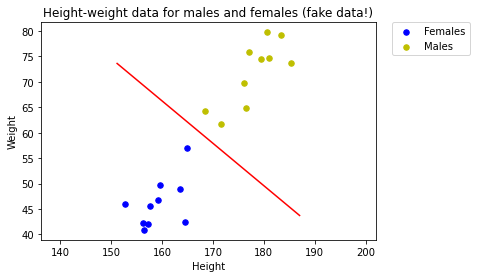

success!


In [12]:
print('Optimal w: [%f %f] b: %f' % (w[0,0],w[1,0],b))

axes = plot_mf(Xf, Xm)
plot_w(axes, w, b)
plt.show()

# Test function: Do not remove
assert w.shape == 2 or w.shape ==(2,) or w.shape == (2,1), 'Size of w is incorrect'
assert w[0] > 0 and w[1] > 0 and w[0] <= 1 and w[1] <= 1, 'w value is incorrect'
assert isinstance(b, (float, int)), 'Type of b is incorrect'
assert b < 0, 'b value is incorrect'

print("success!")
# End Test function

**Expected result (Or look-alike)**:\
Optimal w: [0.640061 0.768324] b: -153.309495

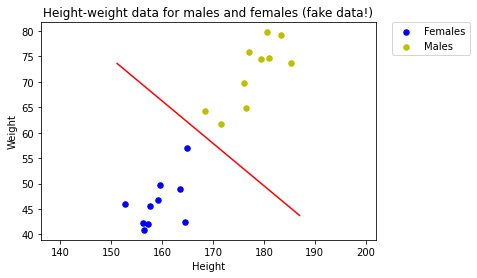

Here's some code to get the prediction accuracy of a linear SVM with parameters $\mathbf{w}$ and $b$ already identified:

In [13]:
def predict_linear(X,w,b):
    s = X@w+b
    s[s >= 0] = 1
    s[s < 0] = -1
    return s
y_pred = predict_linear(X,w,b)
accuracy = np.sum(y_pred==y)/y.size
print(accuracy)

1.0


## Exercise 2 (in lab): non-separable data (5 points)

Take the example of the annulus from the logistic regression lab. Verify that cvxopt cannot find a decision boundary for this case. Show your results in your lab report.

**Note**: You don't need to separate the data into train/test subsets.

In [14]:
# Generate data for class 1
mu_1 = np.array([1.0, 2.0])
sigma_1 = 1
num_sample = 100
cov_mat = np.matrix([[sigma_1,0],[0,sigma_1]])
X1 = np.random.multivariate_normal(mean= mu_1, cov=cov_mat, size = num_sample)

# Generate data for class 2
angle = np.random.uniform(0, 2*np.pi, num_sample)
d =  np.random.normal(np.square(3*sigma_1),np.square(.5*sigma_1),num_sample)
X2 = np.array([X1[:,0] + d*np.cos(angle), X1[:,1] + d*np.sin(angle)]).T

# Combine X1 and X2 into single dataset
X_annulus = np.concatenate([X1, X2],axis = 0)
y_annulus = np.append(-np.ones(num_sample),np.ones(num_sample))[:,np.newaxis]

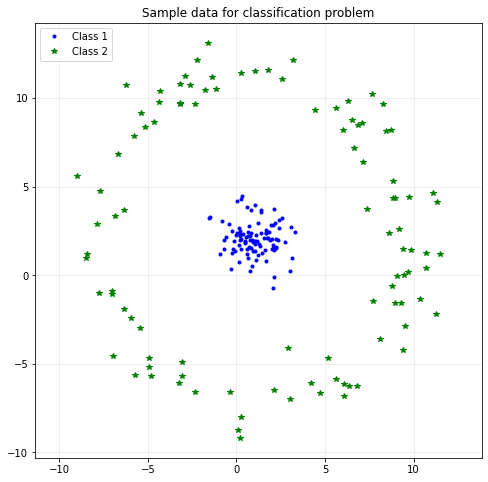

In [15]:
def plot_annulus(X1, X2):
    ax = plt.axes() 
    plt.title('Sample data for classification problem')
    plt.grid(axis='both', alpha=.25)
    plt.plot(X1[:,0],X1[:,1],'b.', label = 'Class 1')
    plt.plot(X2[:,0],X2[:,1],'g*', label = 'Class 2')
    plt.legend(loc=2)
    ax.set_aspect('equal', 'datalim')
    return ax

fig1 = plt.figure(figsize=(8,8))
plot_annulus(X1, X2)
plt.show()


### Exercise 2.1: Fill in Q, c, A, B for the annulus data and find w and b

Here you just have to repeat the same process as in Exercise 1 but with the annulus data generated above.

In [16]:
# Try to use try/catch to get output
get_error = False
try:
    Q = None
    c = None
    A = None
    B = None
    x = None
    w = None
    b = None
    # YOUR CODE HERE
    A, B, c, Q = ABcQ_matrix(X_annulus, y_annulus)
    x = wts_cvxopt(Q, c, A, B)
    w, b = wts_bias(x)
    
    output_str = 'Optimal w: [%f %f] b: %f' % (w[0,0],w[1,0],b)
    get_error = False
except Exception as e:
    output_str = e
    get_error = True

     pcost       dcost       gap    pres   dres
 0:  3.3281e-04  1.9728e+02  3e+02  2e+00  2e-13
 1:  3.0882e-08  4.3682e+02  6e+00  1e+00  9e-14
 2:  2.9265e-12  3.4597e+04  4e+00  1e+00  2e-11
 3:  2.9245e-16  2.6577e+08  3e+02  1e+00  2e-07
 4:  2.9245e-20  2.0410e+14  3e+06  1e+00  6e-02
 5:  2.9245e-24  1.5674e+22  2e+12  1e+00  8e+06
 6:  2.4905e-26  1.1852e+32  4e+20  1e+00  7e+16
 7:  2.2101e-26  8.3034e+39  3e+28  1e+00  3e+24
 8:  2.9954e-26  2.9937e+46  1e+35  1e+00  2e+31
 9:  4.5943e-26  1.1379e+53  4e+41  1e+00  3e+37
10:  5.8051e-26  1.5957e+60  5e+48  1e+00  6e+44
11:  8.9199e-26  4.0098e+67  1e+56  1e+00  5e+51
12:  8.2247e-26  9.5647e+74  3e+63  1e+00  3e+59
13:  7.0143e-26  6.8516e+81  2e+70  1e+00  2e+66
14:  7.8534e-26  9.1900e+88  3e+77  1e+00  3e+73
15:  5.7829e-26  4.9272e+96  2e+85  1e+00  3e+81
16:  7.8073e-26  1.6082e+104  5e+92  1e+00  1e+89
17:  8.1867e-26  7.5825e+110  2e+99  1e+00  3e+95
18:  5.9799e-26  2.9463e+118  1e+107  1e+00 2e+103
19:  8.9632e-26  

In [17]:
print(output_str)

# Test function: Do not remove
assert Q.shape == (3, 3) and Q[2,2] == Q[0,1] and Q[2,0] == 0 and Q[0,0] == Q[1,1] and Q[0,0] == 1, 'Q value is incorrect'
assert c.shape == 3 or c.shape == (3,) or c.shape == (3,1), 'Size of c is incorrect'
assert np.all((c == 0)), 'c value is incorrect'
assert A.shape == (200,3), 'Size of A is incorrect'
assert str(output_str) == 'domain error' or "'NoneType' object is not subscriptable" or get_error, 'Output incorrect'

print("success!")
# End Test function

domain error
success!


**Expected result**: Show that there was an error and that the optimization did not converge.

## Generalized Lagrangian optimization for SVMs

Now we consider the generalized Lagrangian for the SVM. This technique is suitable for solving problems of the form
  $$ \begin{array}{rl}
    \min_{\mathbf{w}} & f(\mathbf{w}) \\
    \text{subject to} & g_i(\mathbf{w}) \le 0, i \in 1..k \\
                      & h_i(\mathbf{w}) = 0, i \in 1..l
   \end{array}$$

The generalized Lagrangian is
$$\cal{L}(\mathbf{w},\mathbf{\alpha},\mathbf{\beta}) = f(\mathbf{w}) + \sum_{i=1}^k \alpha_i g_i(\mathbf{w}) + \sum_{i=1}^l \beta_i h_i(\mathbf{w}),$$
which has been cleverly arranged to be equal to $f(\mathbf{w})$ whenever $\mathbf{w}$ satisfies the constraints and $\infty$ otherwise.

### Primal and dual Lagrangian problems

The primal problem is to find
$$p^* = \min_{\mathbf{w}}\theta_{\cal P}(\mathbf{w}) = \min_\mathbf{w}\max_{\mathbf{\alpha},\mathbf{\beta},\alpha_i \ge 0} {\cal L}(\mathbf{w},\mathbf{\alpha},\mathbf{\beta})$$
and the dual problem is to find
$$d^* = \max_{\mathbf{\alpha},\mathbf{\beta},\alpha_i \ge 0} \theta_{\cal D}(\mathbf{\alpha},\mathbf{\beta}) =  \max_{\mathbf{\alpha},\mathbf{\beta},\alpha_i \ge 0} \min_\mathbf{w}{\cal L}(\mathbf{w},\mathbf{\alpha},\mathbf{\beta}).$$
If $f$ is convex, the $g_i$'s are affine, the $h_i$'s are convex, and the $g_i$'s are strictly
feasible, it turns out that the solutions to the primal and dual problem are the same, and the KKT conditions hold:
$$ \begin{array}{rcl}
  \frac{\partial}{\partial w_i}{\cal L}(\mathbf{w}^*,\mathbf{\alpha}^*,\mathbf{\beta}^*) & = & 0, i \in 1..n \\
  \frac{\partial}{\partial \beta_i}{\cal L}(\mathbf{w}^*,\mathbf{\alpha}^*,\mathbf{\beta}^*) & = & 0, i \in 1..l \\
  \alpha_i^*g_i(\mathbf{w}^*) & = & 0, i \in 1..k \\
  g_i(\mathbf{w}^*) & \le & 0, i \in 1..k \\
  \alpha_i^* & \ge & 0, i \in 1..k
  \end{array} $$

### Solving the dual Lagrangian problem

The dual problem (finding $\mathbf{\alpha}$ maximizing
the Lagrangian with the optimal $\mathbf{w}$ turns out to be easiest to solve and gives us the ability to use kernels other than the linear (inner product) kernel.

We first solve for $\mathbf{w}$ assuming fixed $\mathbf{\alpha}$ and $\mathbf{\beta}$ (we don't have equality constraints though, so no need for $\mathbf{\beta}$).

We need to rewrite the SVM constraints in the necessary form with $g_i(\mathbf{w})=0$. For the SVM, the constraints are
$$g_i(\mathbf{w},b) = -y^{(i)}(\mathbf{w}^\top\mathbf{x}^{(i)} + b) + 1 \ge 0.$$
Using that definition of $g_i(\mathbf{w},b)$, we obtain the Lagrangian
$${\cal L}(\mathbf{w},b,\mathbf{\alpha}) = \frac{1}{2}\|\mathbf{w}\|^2 - \sum_{i=1}^m\alpha_i\left[ y^{(i)}(\mathbf{w}^\top\mathbf{x}^{(i)} + b) -1 \right] $$
Taking the gradient of ${\cal L}$ with respect to $\mathbf{w}$ and setting it to 0, we obtain

$$\nabla_\mathbf{w}{\cal L}(\mathbf{w},b,\mathbf{\alpha}) = \mathbf{w} - \sum_{i=1}^m\alpha_i y^{(i)} \mathbf{x}^{(i)} = 0,$$
which gives us

$$\mathbf{w}=\sum_{i=1}^m\alpha_i y^{(i)} \mathbf{x}^{(i)}.$$

From $\frac{\partial {\cal L}}{\partial b} = 0$, we obtain
$$\sum_{i=1}^m \alpha_i y^{(i)} = 0,$$
which is interesting (think about what it means also considering that $\alpha_i > 0$ only for examples on the margin.
Unfortunately it doesn't help us find $b$! In any case, we plug this definition for the optimal $\mathbf{w}$ into the original Lagrangian,
to obtain
$${\cal L}(\mathbf{w},b,\mathbf{\alpha}) = \sum_{i=1}^m \alpha_i - \frac{1}{2}\sum_{i,j=1}^m y^{(i)} y^{(j)} \alpha_i \alpha_j (\mathbf{x}^{(i)})^\top\mathbf{x}^{(j)} - b\sum_{i=1}^m \alpha_i y^{(i)}. $$
We already know that the last term is 0, so we get
$${\cal L}(\mathbf{w},b,\mathbf{\alpha}) = \sum_{i=1}^m \alpha_i - \frac{1}{2}\sum_{i,j=1}^m y^{(i)} y^{(j)} \alpha_i \alpha_j \left< \mathbf{x}^{(i)},\mathbf{x}^{(j)} \right> . $$
OK! We've eliminated $\mathbf{w}$ and $b$ from the optimization. Now we just need to maximize ${\cal L}$ with respect to $\mathbf{\alpha}$.
This gives us the final (dual) optimization problem
$$ \begin{array}{rl}
  \max_{\mathbf{\alpha}} & W(\mathbf{\alpha}) = \sum_{i=1}^m \alpha_i - \frac{1}{2} \sum_{i,j=1}^m y^{(i)} y^{(j)} \alpha_i \alpha_j \left< \mathbf{x}^{(i)}, \mathbf{x}^{(j)} \right> \\
  \text{such that} & \alpha_i \ge 0, i \in 1..m \\
                   & \sum_{i=1}^m \alpha_i y^{(i)} = 0
\end{array} $$
This turns out to be QP again!

Aside: once we solve for $\mathbf{\alpha}$, we obtain $\mathbf{w}$ according to the equation above, then it turns out that the optimal $b$ can be obtained as in
the lecture notes.

### QP solution to dual problem

We need to negate our objective function to turn the max (SVM formulation) into a min (QP formalation).

For the second term of $W(\mathbf{\alpha})$, first let $\mathtt{K}$ be the kernel matrix with $\mathtt{K}_{ij} = \left< \mathbf{x}^{(i)}, \mathbf{x}^{(j)} \right>$. Then $\mathbf{\alpha}^\top \text{diag}(\mathbf{y}) \mathtt{K} \text{diag}(\mathbf{y}) \mathbf{\alpha}$ gives us the summation in the second term ($\text{diag}(\mathbf{y})$ is just the square diagonal matrix with $\mathbf{y}$ as its diagonal).

The (negated) first term of $W(\mathbf{\alpha})$ can be written in QP form with $\mathbf{c} = \begin{bmatrix} -1 & -1 & \ldots \end{bmatrix}^\top$.

So that gives us our QP setup:
$$ \mathtt{Q} = \text{diag}(\mathbf{y}) \mathtt{K} \text{diag}(\mathbf{y}) \; \; \;
   \mathbf{c} = \begin{bmatrix} -1 \\ -1 \\ \vdots \end{bmatrix} $$

$$\mathtt{A} = -\mathtt{I}_{m\times m} \;\;\;
  \mathbf{b} = \begin{bmatrix} 0 \\ 0 \\ \vdots \end{bmatrix} $$

$$\mathtt{E} = \mathbf{y}^\top \;\;\;
  \mathbf{d} = \begin{bmatrix} 0 \end{bmatrix}. $$

OK, now the code:

In [18]:
m = X.shape[0];
n = X.shape[1];

# Transform data set so that each attribute has a
# mean of 0 and a standard deviation of 1

def preprocess(X):
    means = X.mean(0);
    scales = 1/np.std(X,0);
    Xh = np.concatenate([X.T,np.ones([1,20])],0);
    Tm = np.matrix(np.eye(3));
    Tm[0:2,2:3] = -X.mean(0).T;
    Ts = np.matrix(np.eye(3));
    Ts[0:2,0:2] = np.diagflat(scales);
    T = Ts*Tm;
    XX = (T * Xh);
    XX = XX[0:2,:].T;
    return XX, T;

# RBF/Gaussian kernel

def gauss_kernel(X):
    sigma = 0.2
    m = X.shape[0];
    K = np.matrix(np.zeros([m,m]));
    for i in range(0,m):
        for j in range(0,m):
            K[i,j] = (X[i,:] - X[j,:]).reshape(1,-1) @ (X[i,:] - X[j,:]).reshape(-1,1) #||X-Z||^2 = (X-Z).T @(X-Z)
    K = np.exp(-K/(2*sigma*sigma))      
    return K;

def linear_kernel(X):
    m = X.shape[0];
    K = np.matrix(np.zeros([m,m]));
    for i in range(0,m):
        for j in range(0,m):
            K[i,j] = (X[i,:].reshape(1,-1)@X[j,:].reshape(-1,1))
    return K;

## Exercise 3 (in lab): linearly separable data (15 points)

Take the example data from Exercise 1. Verify that you can use the dual optmization to find the decision boundary for such "easy" cases. Show your results in your lab report.

### Exercise 3.1: Find Q, c, A, b, E, d for input into cvxopt_solve_qp function (10 points)

Here you need to set up the QP variables appropriate to get the solution to the dual optimization problem. When we pass them to cvxopt, we should get $\mathbf{\alpha}^*$, the optimal Lagrangian parameters. We know from inspection which examples in the original data will be the support vectors with non-zero $\alpha_i$'s.

In [19]:
Q = None
c = None
A = None
b = None
E = None
d = None

K = linear_kernel(X)
# YOUR CODE HERE
# print(np.diag(np.array(y).squeeze()))

def QcABEd(X, y, K):
    Q = np.diag(np.array(y).squeeze()) @ K @ np.diag(np.array(y).squeeze()) #shape mxm
    print(Q.shape)

    c = -np.ones(shape = (X.shape[0],)) #shape of c -> (m,)
    print(c.shape)

    A = -np.eye(N = X.shape[0]) #shape of A -> (m,m)   its an identity matrix
    print(A.shape)

    B = np.zeros(shape = (X.shape[0],)) #shape (m, )
    print(B.shape)

    E = y.T
    print(E.shape)

    d = np.zeros(shape = (1,))
    print(d.shape)
    
    return Q, c, A, B, E, d


Q, c, A, B, E, d = QcABEd(X,y, K)


def alphastar(Q, c, A, B, E, d): 
    x = cvxopt_solve_qp(Q, c, A, B, E, d)
    x = np.array(x)
    x = x.squeeze()
    return x

alpha_star = alphastar(Q, c, A, B, E, d)


(20, 20)
(20,)
(20, 20)
(20,)
(1, 20)
(1,)
     pcost       dcost       gap    pres   dres
 0: -2.7646e+00 -4.9725e+00  5e+01  6e+00  2e+00
 1: -6.4101e+00 -3.8299e+00  1e+01  2e+00  6e-01
 2: -5.0055e+00 -1.2719e+00  7e+00  8e-01  2e-01
 3: -5.1552e-02 -4.0648e-02  5e-01  3e-02  1e-02
 4: -1.8200e-02 -3.5404e-02  2e-02  9e-18  2e-13
 5: -3.0877e-02 -3.1392e-02  5e-04  3e-18  1e-13
 6: -3.1245e-02 -3.1250e-02  5e-06  4e-18  2e-13
 7: -3.1248e-02 -3.1249e-02  5e-08  6e-18  2e-13
Optimal solution found.


In [20]:
print('Q rank: %d' % np.linalg.matrix_rank(Q))
print("Optimal alpha:\n", alpha_star)

# Test function: Do not remove
assert Q.shape == (20, 20), 'Size of Q is incorrect'
assert np.linalg.matrix_rank(Q) == 2, 'Q rank is incorrect'
assert np.all((c == -1)), 'c value is incorrect'
assert A.shape == (20,20), 'Size of A is incorrect'
assert np.all((B == 0)), 'b value is incorrect'
assert np.array_equal(np.round(E,1), np.round(y.T,1)), 'E value is incorrect'
assert d.shape == (1,) or d.shape == 1 or d.shape == (1,1) , 'Size of d is incorrect'
assert np.all((d == 0)), 'd value is incorrect'
assert alpha_star.shape == (20,) or alpha_star.shape == 20 or alpha_star.shape == (20,1), 'Size of alpha_star is incorrect'

print("success!")
# End Test function

Q rank: 2
Optimal alpha:
 [3.12484796e-02 1.13821985e-09 7.68004003e-10 6.22346942e-10
 6.43114906e-10 8.93974185e-10 6.60695980e-10 4.31409827e-10
 6.68557407e-10 1.19689394e-09 1.56332821e-02 1.56151999e-02
 5.00606721e-10 6.71834910e-10 4.89168003e-10 4.93113729e-10
 4.90935291e-10 4.85894509e-10 9.54348935e-10 4.42078646e-10]
success!


**Expected Result (or look a like):**\
Q rank: 2\
Optimal alpha:\
 [3.12484796e-02 1.13821985e-09 7.68004003e-10 6.22346942e-10\
 6.43114906e-10 8.93974184e-10 6.60695980e-10 4.31409827e-10\
 6.68557407e-10 1.19689394e-09 1.56332821e-02 1.56151999e-02\
 5.00606721e-10 6.71834910e-10 4.89168003e-10 4.93113729e-10\
 4.90935291e-10 4.85894509e-10 9.54348935e-10 4.42078646e-10]

### Exercise 3.2: write get_wb function (5 points)

Next, try to write the `get_wb()` function that, given the optimal $\alpha_i$'s, returns
the corresponding $\mathbf{w}$ and $b$. If you get stuck, refer to the handout from lecture,
but it will be better for you to try to figure it out for yourself.

In [21]:
def get_wb(X, y, alpha, K):
    # Find the support vectors
    S = alpha > 1e-6 #True for the value > 1e-6, others False
    XS = None
    yS = None
    alphaS = None
    alphaSyS = None
    w = None
    # Find b
    KS = None
    NS = None
    b = None
    # Normalize w,b
    scalef = None
    w = None
    b = None
    
    # YOUR CODE HERE
    #find support vectors
    S = alpha > 1e-6
    XS = X[S]
    yS = y[S]
    alphaS = alpha[S]
#     print(alphaS)
    alphaSyS = np.multiply(alpha, S.astype(int))
    w = X.T @ np.multiply(alphaSyS.reshape(-1,1), y.reshape(-1,1))
#     print(w.shape)
    
    #find b
    KS = linear_kernel(XS)
#     print(KS)
    NS = XS.shape[0]
    b = 1/NS * np.sum(yS - KS @ np.multiply(alphaS.reshape(-1,1), yS.reshape(-1,1)))
    
    #Normalize w,b
    scalef = np.sqrt(np.sum(np.square(w)))
    w = w/scalef
    b = b/scalef
    
    return w,b

# get_wb(X,y,alpha_star, K)
# print(K.shape)

Optimal w: [0.640062,0.768324] b: -153.309583


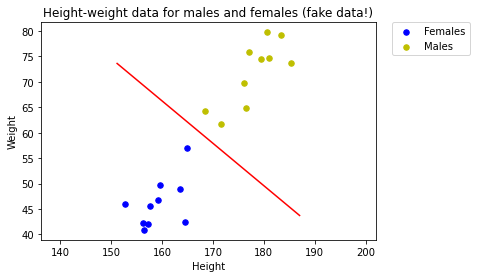

success!


In [22]:
# Test function: Do not remove
w,b = get_wb(X, y, alpha_star, K)

print("Optimal w: [%f,%f] b: %f" % (w[0],w[1],b))

axes = plot_mf(Xf, Xm)
plot_w(axes, w, b)
plt.show()

print("success!")
# End test function

**Expected Result (Or look-alike)**:\
Optimal w: [0.640062,0.768324] b: -153.309583

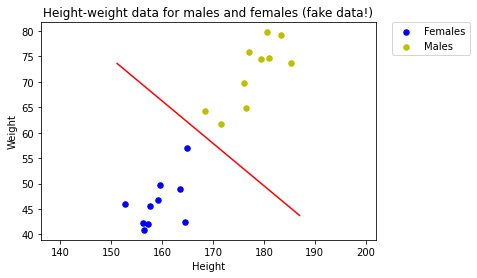

In [23]:
y_pred = predict_linear(X,w,b)
accuracy = np.sum(y_pred==y)/y.size
print(accuracy)

1.0


### Exercise 4.1 (in lab): non-separable data, linear kernel (15 points)

Again, take the example of the annulus from the logistic regression lab. Verify that the dual optimization with the linear kernel still cannot find a decision boundary for this case. Show your results in your lab report.
As before, you'll want to set up $\mathtt{Q}$, $\mathbf{c}$, $\mathtt{A}$, $\mathtt{B}$, $\mathtt{E}$, and $\mathbf{d}$ appropriately but now for the dual optimization problem.

In [24]:
(m, n) = X_annulus.shape
print(X_annulus.shape)
K_annulus = linear_kernel(X_annulus);

Q_annulus = None
c = None
A = None
B = None
E = None
d = None

# YOUR CODE HERE
Q_annulus, c, A, B, E, d = QcABEd(X_annulus, y_annulus, K_annulus)

(200, 2)
(200, 200)
(200,)
(200, 200)
(200,)
(1, 200)
(1,)


In [25]:
alpha_star_annulus = cvxopt_solve_qp(Q_annulus, c, A, B, E, d)

print("Optimal alpha:", alpha_star_annulus)
# Test function: Do not remove
assert alpha_star_annulus is None, "alpha_star_annulus cannot be calculated."

print("success!")
# End test function

     pcost       dcost       gap    pres   dres
 0: -1.9728e+02 -4.4815e+02  3e+02  2e-14  2e+00
 1: -4.3682e+02 -4.4242e+02  6e+00  6e-14  1e+00
 2: -3.4597e+04 -3.4601e+04  4e+00  4e-12  1e+00
 3: -2.6308e+08 -2.6308e+08  7e+02  3e-08  1e+00
 4: -5.9702e+08 -5.9703e+08  1e+03  7e-08  1e+00
Terminated (singular KKT matrix).
Optimal alpha: None
success!


In [26]:
get_error = False
try:
    w,b = get_wb(X_annulus, y_annulus, alpha_star_annulus, K_annulus)

    output_str = "Optimal w: [%f,%f] b: %f" % (w[0],w[1],b)
    plot_mf(Xf,Xm)
    plot_w(w,b)
    get_error = False
except Exception as e:
    output_str = str(e)
    get_error = True
    
print(output_str)
# Test function: Do not remove
assert str(output_str) == 'domain error' or "'NoneType' object is not subscriptable" or get_error, 'Output incorrect'

print("success!")
# End Test function

'>' not supported between instances of 'NoneType' and 'float'
success!


**Expected Result**: Error due to `alpha_star` being `None`.

### Exercise 5.1 (in lab): "easy" non-separable data, Gaussian (RBF) kernel with non-overlapping data (10 points)

Now we'll use the Gaussian (radial basis function) kernel instead of the linear kernel implemented in the code above and verify that we can correctly solve the easy non-separable data where a transformation to a feature space makes the data linearly separable. We already know that a simple polar transformation will give us linearly separable data, but it turns out we can achieve the same thing using the RBF kernel.

By the way, you might think about which solution is better for our annulus problem: the explicit transformation or the RBF kernel. See how many support vectors we get before you decide.

In [27]:
(m, n) = X_annulus.shape
K_annulus = None
Q_annulus = None
c = None
A = None
B = None
E = None
d = None

# YOUR CODE HERE
K_annulus = gauss_kernel(X_annulus)
print("K_annulus shape", K_annulus.shape)
Q_annulus, c, A, B, E, d = QcABEd(X_annulus, y_annulus, K_annulus)

K_annulus shape (200, 200)
(200, 200)
(200,)
(200, 200)
(200,)
(1, 200)
(1,)


In [28]:
alpha_star_annulus = cvxopt_solve_qp(Q_annulus, c, A, B, E, d)

print('Q rank: %d' % np.linalg.matrix_rank(Q_annulus))
print("Optimal alpha:")
print(alpha_star_annulus[:5])

# Test function: Do not remove
assert np.linalg.matrix_rank(Q_annulus) > 2, "Q rank is incorrect"
assert alpha_star_annulus is not None, "alpha_star_annulus cannot be calculated."

print("success!")
# End test function

     pcost       dcost       gap    pres   dres
 0: -4.9608e+01 -1.3747e+02  9e+01  1e-14  2e+00
 1: -5.7564e+01 -6.4996e+01  7e+00  1e-15  3e-01
 2: -6.0467e+01 -6.2084e+01  2e+00  8e-15  4e-02
 3: -6.0590e+01 -6.0797e+01  2e-01  4e-15  3e-03
 4: -6.0606e+01 -6.0630e+01  2e-02  1e-14  2e-04
 5: -6.0609e+01 -6.0611e+01  2e-03  6e-15  2e-05
 6: -6.0609e+01 -6.0609e+01  6e-05  9e-15  3e-07
 7: -6.0609e+01 -6.0609e+01  2e-06  8e-15  7e-09
Optimal solution found.
Q rank: 200
Optimal alpha:
[ 4.90e-07]
[ 2.42e-07]
[ 4.01e-07]
[ 6.60e-01]
[ 3.89e-01]

success!


**Expected result (or look-alike)**:\
     pcost       dcost       gap    pres   dres\
 0: -5.0795e+01 -1.3928e+02  9e+01  1e-15  2e+00\
 1: -5.9073e+01 -6.6466e+01  7e+00  2e-14  3e-01\
 2: -6.2076e+01 -6.3563e+01  1e+00  1e-14  4e-02\
 3: -6.2184e+01 -6.2423e+01  2e-01  8e-15  5e-03\
 4: -6.2205e+01 -6.2232e+01  3e-02  3e-14  5e-04\
 5: -6.2209e+01 -6.2209e+01  7e-04  4e-14  6e-06\
 6: -6.2209e+01 -6.2209e+01  1e-05  1e-14  7e-08\
Optimal solution found.\
Q rank: 200\
Optimal alpha:\
[5.77224260e-01 1.31648362e+00 1.17475881e+00 4.38419640e-01 8.16578932e-07]

With the nonlinear kernel, we no longer have a $\mathbf{w}$ and $b$ in the input space. First,
let's revise our prediction method using just support vectors, their $\alpha_i$'s, and their
labels:

In [29]:
def predict(x, X, y, alpha): #prediction part in lecture note (my note)
    s = []
    sigma = 0.2
    for j in range(x.shape[0]): #loop for each points to predict, here x represent test sets
        ss = 0
        for i in range(X.shape[0]):  #loop for each points in training set, X represent training sets
            ss += alpha[i]*y[i]*np.exp((-(X[i]-x[j])@(X[i]-x[j]))/(2*sigma*sigma))
        s.append(ss)
    s = np.array(s)
    s[s >= 0] = 1
    s[s < 0] = -1
    return s
    
y_pred = predict(X_annulus, X_annulus, y_annulus, alpha_star_annulus)
np.sum(y_annulus == y_pred)/y_annulus.size

1.0

Another problem is graphing the decision boundary. Since the decision boundary is in feature space, which is infinite dimensional in the case of the RBF kernel, we can't exactly graph it! Instead, consider the 2-dimensional input space, let's obtain the prediction of the model at each point in a regular grid over the space, then let's plot the resulting mesh on top of the data.

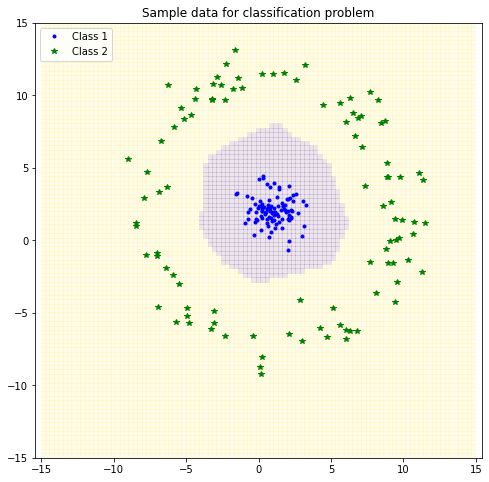

In [30]:
x_series = np.linspace(-15, 15, 100)
y_series = np.linspace(-15, 15, 100)

x_mesh, y_mesh = np.meshgrid(x_series, y_series)

x_mesh = x_mesh.reshape(-1, 1)
y_mesh = y_mesh.reshape(-1, 1)

mesh = np.append(x_mesh, y_mesh, axis=1)
y_pred = predict(mesh, X_annulus, y_annulus, alpha_star_annulus)

x_mesh = x_mesh.reshape(100, 100)
y_mesh = y_mesh.reshape(100, 100)
y_pred = y_pred.reshape(100, 100)

fig1 = plt.figure(figsize=(8,8))
ax = plot_annulus(X1, X2)
ax.pcolormesh(x_mesh, y_mesh, y_pred, cmap='viridis', shading='auto', alpha=0.1)
plt.show()

**Expected Result**:

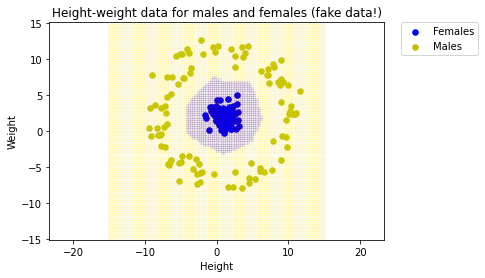

## Exercise 6 (take home): more difficult non-separable data

Now find or generate a dataset in which the decision boundary is nonlinear AND the data overlap along that nonlinear boundary. Show that the result.

### Generating Dataset

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import cvxopt

np.random.seed(32)


mu_1 = np.array([1.0, 2.0])
sigma_1 = 1
num_sample = 100
cov_mat = np.matrix([[sigma_1,0],[0,sigma_1]])
X = np.random.multivariate_normal(mean= mu_1, cov=cov_mat, size = num_sample)


# Generate data for class 1
angle = np.random.uniform(0, 2*np.pi, num_sample)
d =  np.random.normal(np.square(2.5*sigma_1),np.square(1*sigma_1),num_sample)
X1 = np.array([X[:,0] + d*np.cos(angle), X[:,1] + d*np.sin(angle)]).T

# Generate data for class 2
angle = np.random.uniform(0, 2*np.pi, num_sample)
d =  np.random.normal(np.square(3*sigma_1),np.square(1.2*sigma_1),num_sample)
X2 = np.array([X[:,0] + d*np.cos(angle), X[:,1] + d*np.sin(angle)]).T

# Combine X1 and X2 into single dataset
X_annulus = np.concatenate([X1, X2],axis = 0)
y_annulus = np.append(-np.ones(num_sample),np.ones(num_sample))[:,np.newaxis]

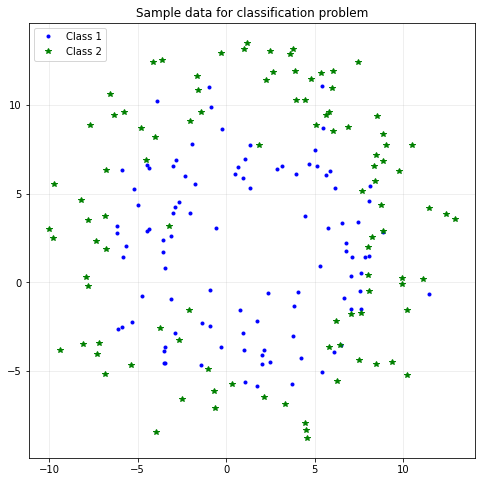

In [32]:
def plot_annulus(X1, X2):
    ax = plt.axes() 
    plt.title('Sample data for classification problem')
    plt.grid(axis='both', alpha=.25)
    plt.plot(X1[:,0],X1[:,1],'b.', label = 'Class 1')
    plt.plot(X2[:,0],X2[:,1],'g*', label = 'Class 2')
    plt.legend(loc=2)
    ax.set_aspect('equal', 'datalim')
    return ax

fig1 = plt.figure(figsize=(8,8))
plot_annulus(X1, X2)
plt.show()

In [33]:
def gausskernel(X, sigma):
    m = X.shape[0];
    K = np.matrix(np.zeros([m,m]));
    for i in range(0,m):
        for j in range(0,m):
            K[i,j] = (X[i,:] - X[j,:]).reshape(1,-1) @ (X[i,:] - X[j,:]).reshape(-1,1) #||X-Z||^2 = (X-Z).T @(X-Z)
    K = np.exp(-K/(2*sigma*sigma))      
    return K;



In [34]:
def quadparams(X, y, K, c):
    Q = np.diag(np.array(y).squeeze()) @ K @ np.diag(np.array(y).squeeze()) #shape mxm
    C = -np.ones(shape = (X.shape[0],)) #shape of c -> (m,)
    A = np.eye(N = X.shape[0]) #shape of A -> (m,m)   its an identity matrix
    B = np.zeros(shape = (X.shape[0],)) #shape (m, )
    B = B + c
    E = y.T
    d = np.zeros(shape = (1,))    
    return Q, C, A, B, E, d

def alphastar(Q, c, A, B, E, d): 
    x = cvxopt_solve_qp(Q, c, A, B, E, d)
    x = np.array(x)
    x = x.squeeze()
    return x

def predict(x, X, y, alpha, sigma): #prediction part in lecture note (my note)
    s = []
    for j in range(x.shape[0]): #loop for each points to predict, here x represent test sets
        ss = 0
        for i in range(X.shape[0]):  #loop for each points in training set, X represent training sets
            ss += alpha[i]*y[i]*np.exp((-(X[i]-x[j])@(X[i]-x[j]))/(2*sigma*sigma))
        s.append(ss)
    s = np.array(s)
    s[s >= 0] = 1
    s[s < 0] = -1
    return s

K_annulus shape (200, 200)
     pcost       dcost       gap    pres   dres
 0: -7.4524e+01 -2.3563e+01  1e+02  3e+01  3e-16
 1: -4.6230e+01 -1.2772e+01  2e+01  6e+00  2e-16
 2: -8.5391e+00 -2.1408e+00  8e+00  1e+00  6e-16
 3: -2.0865e+00 -1.9871e+00  1e-01  2e-02  4e-16
 4: -1.9880e+00 -1.9870e+00  1e-03  2e-04  7e-16
 5: -1.9870e+00 -1.9870e+00  1e-05  2e-06  3e-16
 6: -1.9870e+00 -1.9870e+00  1e-07  2e-08  3e-16
Optimal solution found.
Accuracy is for c=0.01 and sigma=0.5 is: 0.96


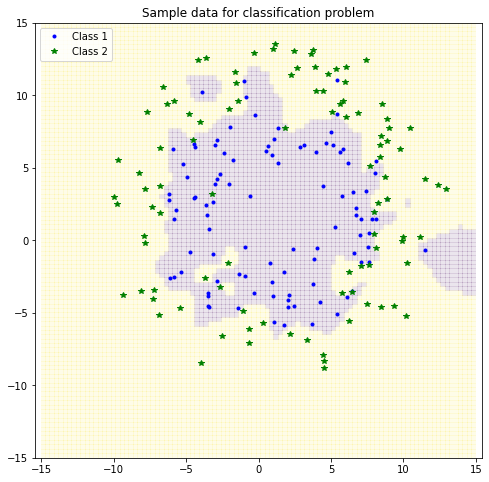

K_annulus shape (200, 200)
     pcost       dcost       gap    pres   dres
 0: -7.8970e+01 -3.5401e+01  1e+02  2e+01  3e-16
 1: -5.4114e+01 -2.7191e+01  1e+01  4e+00  2e-16
 2: -2.8390e+01 -1.9195e+01  8e+00  1e+00  5e-16
 3: -1.8660e+01 -1.8702e+01  2e-01  8e-03  4e-16
 4: -1.8701e+01 -1.8702e+01  2e-03  8e-05  2e-16
 5: -1.8702e+01 -1.8702e+01  2e-05  8e-07  2e-16
 6: -1.8702e+01 -1.8702e+01  2e-07  8e-09  2e-16
Optimal solution found.
Accuracy is for c=0.1 and sigma=0.5 is: 0.96


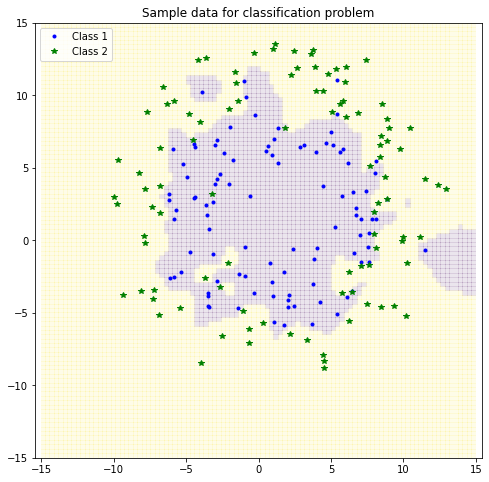

K_annulus shape (200, 200)
     pcost       dcost       gap    pres   dres
 0: -1.0368e+02 -9.3284e+01  7e+02  2e+00  2e+00
 1: -4.8154e+01 -1.4574e+02  1e+02  3e-14  5e-16
 2: -8.5416e+01 -1.0051e+02  2e+01  9e-15  2e-16
 3: -9.0691e+01 -9.2585e+01  2e+00  2e-15  2e-16
 4: -9.1395e+01 -9.1568e+01  2e-01  1e-15  2e-16
 5: -9.1461e+01 -9.1469e+01  9e-03  4e-15  2e-16
 6: -9.1465e+01 -9.1465e+01  4e-04  2e-14  2e-16
 7: -9.1465e+01 -9.1465e+01  2e-05  5e-14  2e-16
Optimal solution found.
Accuracy is for c=1 and sigma=0.5 is: 0.97


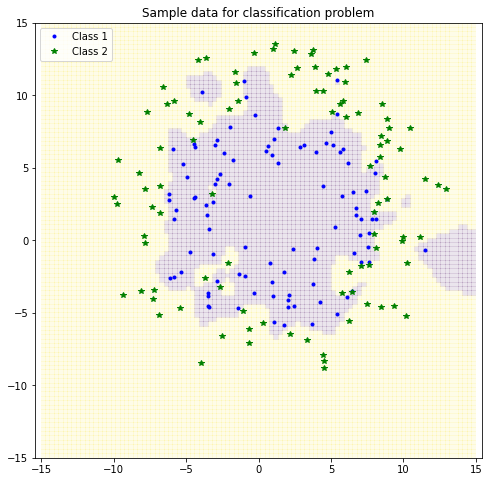

K_annulus shape (200, 200)
     pcost       dcost       gap    pres   dres
 0:  1.6242e+03 -1.5704e+03  6e+03  3e-01  9e+00
 1: -1.0471e+02 -7.5797e+02  7e+02  4e-02  1e+00
 2: -1.6288e+02 -2.4567e+02  8e+01  3e-03  1e-01
 3: -1.6667e+02 -1.7333e+02  7e+00  2e-04  8e-03
 4: -1.6721e+02 -1.6739e+02  2e-01  6e-06  2e-04
 5: -1.6724e+02 -1.6724e+02  5e-03  9e-08  3e-06
 6: -1.6724e+02 -1.6724e+02  2e-04  9e-10  3e-08
 7: -1.6724e+02 -1.6724e+02  3e-06  9e-12  3e-10
Optimal solution found.
Accuracy is for c=10 and sigma=0.5 is: 0.99


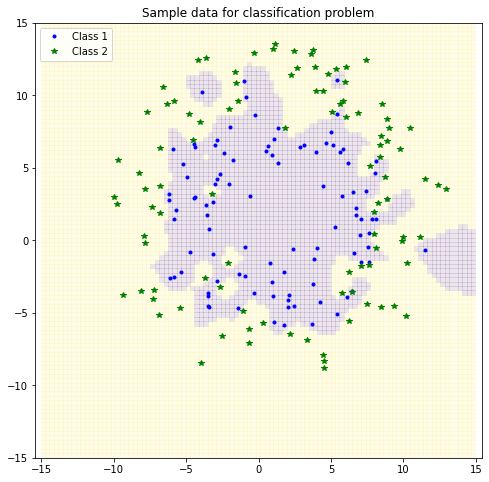

K_annulus shape (200, 200)
     pcost       dcost       gap    pres   dres
 0: -7.5348e+01 -1.7710e+01  2e+02  3e+01  5e-16
 1: -3.6780e+01 -1.2749e+01  3e+01  7e+00  3e-16
 2: -2.0655e+01 -5.4651e+00  2e+01  3e+00  3e-16
 3: -3.9357e+00 -2.0175e+00  7e+00  7e-01  4e-16
 4: -2.0215e+00 -1.9787e+00  1e-01  1e-02  1e-15
 5: -1.9791e+00 -1.9786e+00  1e-03  1e-04  8e-16
 6: -1.9787e+00 -1.9786e+00  1e-05  1e-06  3e-16
 7: -1.9786e+00 -1.9786e+00  1e-07  1e-08  4e-16
Optimal solution found.
Accuracy is for c=0.01 and sigma=1 is: 0.89


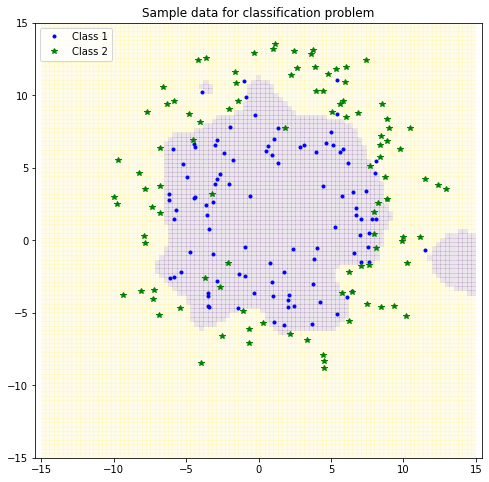

K_annulus shape (200, 200)
     pcost       dcost       gap    pres   dres
 0: -8.0431e+01  5.2898e+01  6e+02  2e+01  1e+00
 1:  1.8237e+01 -2.1569e+01  4e+01  9e-15  7e-16
 2: -1.3517e+01 -1.8030e+01  5e+00  5e-15  5e-16
 3: -1.7743e+01 -1.7865e+01  1e-01  3e-16  3e-16
 4: -1.7864e+01 -1.7865e+01  1e-03  2e-15  3e-16
 5: -1.7865e+01 -1.7865e+01  1e-05  2e-16  3e-16
Optimal solution found.
Accuracy is for c=0.1 and sigma=1 is: 0.89


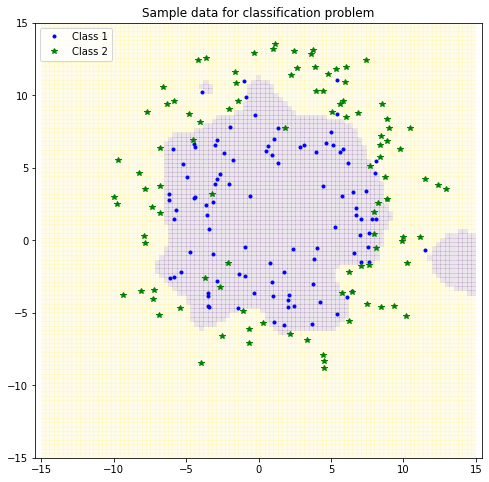

K_annulus shape (200, 200)
     pcost       dcost       gap    pres   dres
 0: -1.1658e+02 -8.0437e+01  9e+02  3e+00  2e+00
 1: -2.4533e+01 -1.6209e+02  1e+02  1e-14  9e-16
 2: -7.5565e+01 -9.3985e+01  2e+01  7e-15  4e-16
 3: -8.2329e+01 -8.5301e+01  3e+00  2e-14  3e-16
 4: -8.3532e+01 -8.3891e+01  4e-01  3e-14  4e-16
 5: -8.3693e+01 -8.3715e+01  2e-02  4e-15  3e-16
 6: -8.3702e+01 -8.3703e+01  1e-03  1e-14  3e-16
 7: -8.3703e+01 -8.3703e+01  7e-05  7e-15  3e-16
Optimal solution found.
Accuracy is for c=1 and sigma=1 is: 0.905


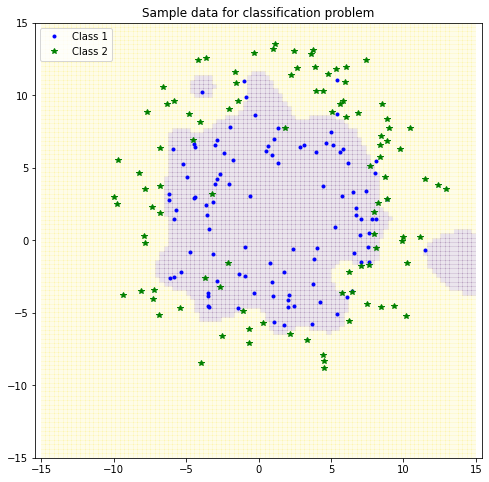

K_annulus shape (200, 200)
     pcost       dcost       gap    pres   dres
 0:  9.9008e+02 -2.0563e+03  1e+04  7e-01  1e+01
 1: -2.3196e+02 -8.4203e+02  6e+02  2e-03  3e-02
 2: -3.2549e+02 -4.7792e+02  2e+02  5e-05  8e-04
 3: -3.5094e+02 -3.7549e+02  2e+01  6e-06  9e-05
 4: -3.5535e+02 -3.5758e+02  2e+00  2e-07  3e-06
 5: -3.5575e+02 -3.5582e+02  7e-02  4e-09  6e-08
 6: -3.5577e+02 -3.5577e+02  3e-03  4e-11  7e-10
 7: -3.5577e+02 -3.5577e+02  1e-04  4e-13  6e-12
Optimal solution found.
Accuracy is for c=10 and sigma=1 is: 0.94


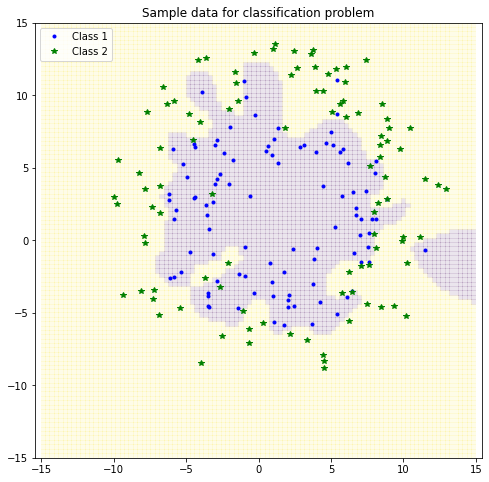

K_annulus shape (200, 200)
     pcost       dcost       gap    pres   dres
 0: -8.4161e+01  8.7630e+01  7e+02  4e+01  1e+00
 1:  3.2459e+01 -4.4650e+00  6e+01  2e+00  5e-02
 2:  1.9001e+00 -2.0666e+00  6e+00  1e-01  4e-03
 3: -1.8128e+00 -1.9598e+00  2e-01  2e-03  7e-05
 4: -1.9579e+00 -1.9594e+00  2e-03  2e-05  7e-07
 5: -1.9594e+00 -1.9594e+00  2e-05  2e-07  7e-09
 6: -1.9594e+00 -1.9594e+00  2e-07  2e-09  7e-11
Optimal solution found.
Accuracy is for c=0.01 and sigma=2 is: 0.825


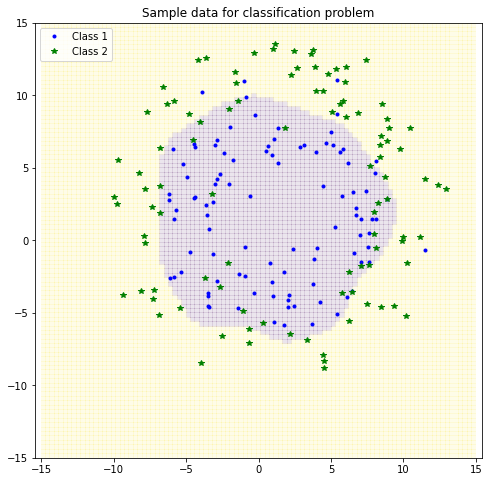

K_annulus shape (200, 200)
     pcost       dcost       gap    pres   dres
 0: -9.0719e+01  7.6050e+01  7e+02  3e+01  1e+00
 1:  3.2441e+01 -2.3375e+01  6e+01  4e-01  2e-02
 2: -8.6001e+00 -1.7346e+01  9e+00  4e-02  1e-03
 3: -1.5193e+01 -1.6057e+01  9e-01  6e-04  3e-05
 4: -1.5892e+01 -1.5950e+01  6e-02  2e-05  6e-07
 5: -1.5932e+01 -1.5945e+01  1e-02  3e-06  1e-07
 6: -1.5942e+01 -1.5944e+01  2e-03  1e-07  6e-09
 7: -1.5944e+01 -1.5944e+01  3e-05  2e-09  9e-11
 8: -1.5944e+01 -1.5944e+01  3e-07  2e-11  9e-13
Optimal solution found.
Accuracy is for c=0.1 and sigma=2 is: 0.825


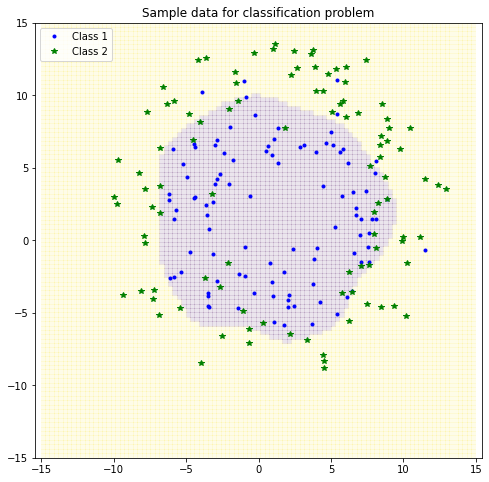

K_annulus shape (200, 200)
     pcost       dcost       gap    pres   dres
 0: -1.4782e+02 -5.3842e+01  1e+03  3e+00  2e+00
 1:  4.7740e+00 -1.8568e+02  2e+02  8e-15  2e-15
 2: -6.4908e+01 -1.0287e+02  4e+01  4e-15  7e-16
 3: -8.1627e+01 -8.8661e+01  7e+00  3e-15  7e-16
 4: -8.4782e+01 -8.6324e+01  2e+00  9e-15  7e-16
 5: -8.5528e+01 -8.5772e+01  2e-01  3e-14  8e-16
 6: -8.5658e+01 -8.5687e+01  3e-02  2e-14  8e-16
 7: -8.5674e+01 -8.5678e+01  3e-03  4e-16  8e-16
 8: -8.5676e+01 -8.5676e+01  6e-05  2e-14  9e-16
Optimal solution found.
Accuracy is for c=1 and sigma=2 is: 0.84


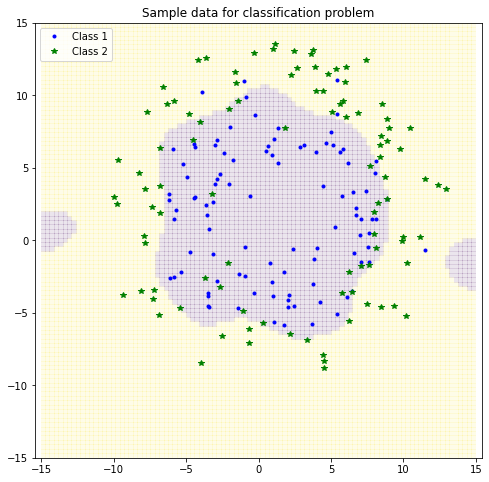

K_annulus shape (200, 200)
     pcost       dcost       gap    pres   dres
 0:  1.2848e+02 -2.7625e+03  2e+04  1e+00  1e+01
 1: -1.8644e+02 -2.0737e+03  2e+03  3e-02  3e-01
 2: -4.1727e+02 -1.2186e+03  8e+02  1e-02  1e-01
 3: -5.3277e+02 -8.2339e+02  3e+02  7e-14  4e-15
 4: -6.1934e+02 -6.7610e+02  6e+01  6e-14  6e-15
 5: -6.3871e+02 -6.5478e+02  2e+01  9e-14  7e-15
 6: -6.4532e+02 -6.4718e+02  2e+00  1e-13  7e-15
 7: -6.4619e+02 -6.4630e+02  1e-01  1e-13  7e-15
 8: -6.4624e+02 -6.4624e+02  2e-03  8e-14  7e-15
 9: -6.4624e+02 -6.4624e+02  2e-05  1e-13  8e-15
Optimal solution found.
Accuracy is for c=10 and sigma=2 is: 0.865


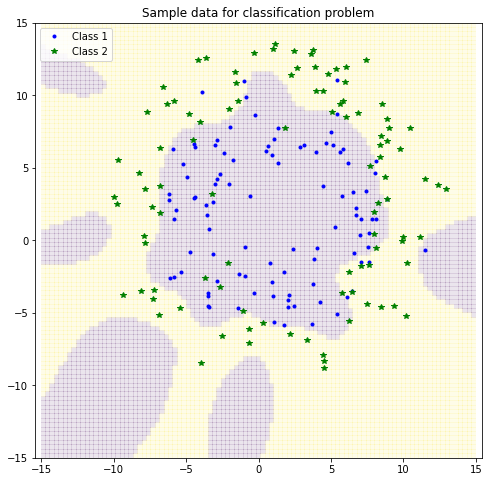

K_annulus shape (200, 200)
     pcost       dcost       gap    pres   dres
 0: -9.2482e+01  1.1330e+02  8e+02  4e+01  1e+00
 1:  4.5804e+01 -7.0774e+00  1e+02  3e+00  8e-02
 2:  5.4566e+00 -2.3675e+00  1e+01  3e-01  9e-03
 3: -1.3108e+00 -1.9570e+00  8e-01  8e-03  2e-04
 4: -1.9370e+00 -1.9468e+00  1e-02  9e-05  3e-06
 5: -1.9467e+00 -1.9468e+00  1e-04  9e-07  3e-08
 6: -1.9468e+00 -1.9468e+00  1e-06  9e-09  3e-10
Optimal solution found.
Accuracy is for c=0.01 and sigma=3 is: 0.805


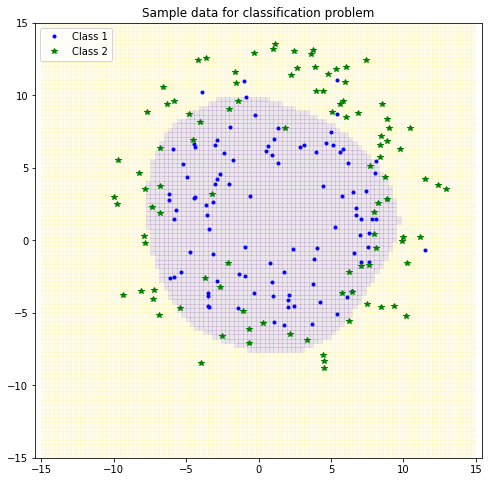

K_annulus shape (200, 200)
     pcost       dcost       gap    pres   dres
 0: -1.0006e+02  1.0257e+02  9e+02  3e+01  1e+00
 1:  4.6810e+01 -2.7783e+01  1e+02  1e+00  5e-02
 2: -2.5902e+00 -1.8694e+01  2e+01  2e-01  7e-03
 3: -1.3203e+01 -1.5479e+01  2e+00  3e-03  1e-04
 4: -1.4451e+01 -1.5019e+01  6e-01  7e-04  3e-05
 5: -1.4575e+01 -1.5009e+01  4e-01  3e-04  1e-05
 6: -1.4862e+01 -1.4947e+01  9e-02  6e-05  3e-06
 7: -1.4930e+01 -1.4943e+01  1e-02  2e-06  1e-07
 8: -1.4941e+01 -1.4942e+01  4e-04  6e-08  3e-09
 9: -1.4942e+01 -1.4942e+01  8e-06  1e-09  4e-11
Optimal solution found.
Accuracy is for c=0.1 and sigma=3 is: 0.81


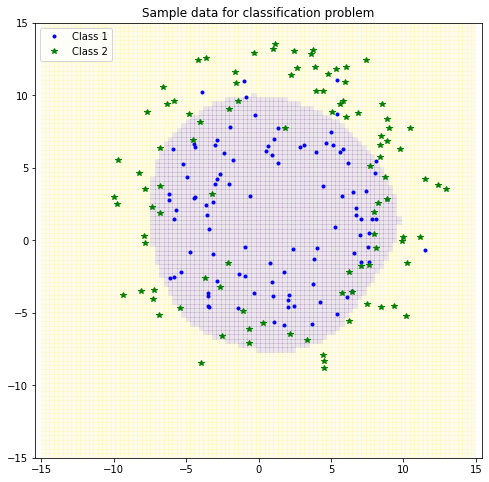

K_annulus shape (200, 200)
     pcost       dcost       gap    pres   dres
 0: -1.6991e+02 -3.1659e+01  2e+03  4e+00  2e+00
 1:  3.2362e+01 -2.1483e+02  2e+02  1e-14  3e-15
 2: -5.0827e+01 -1.1569e+02  6e+01  3e-15  1e-15
 3: -8.0115e+01 -1.0224e+02  2e+01  1e-14  9e-16
 4: -9.2462e+01 -9.6928e+01  4e+00  1e-14  1e-15
 5: -9.4932e+01 -9.5772e+01  8e-01  6e-15  2e-15
 6: -9.5479e+01 -9.5599e+01  1e-01  9e-15  2e-15
 7: -9.5562e+01 -9.5572e+01  1e-02  4e-15  2e-15
 8: -9.5569e+01 -9.5569e+01  4e-04  3e-14  2e-15
 9: -9.5569e+01 -9.5569e+01  1e-05  2e-14  2e-15
Optimal solution found.
Accuracy is for c=1 and sigma=3 is: 0.83


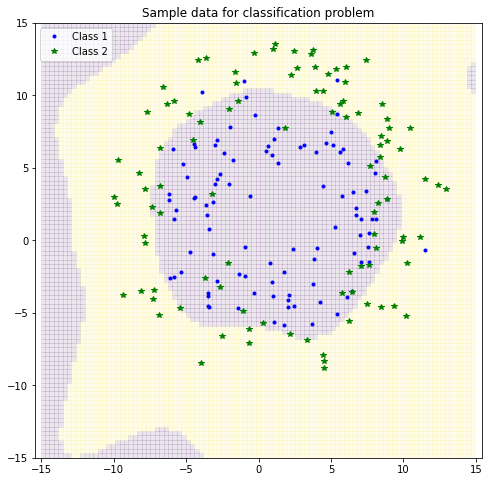

K_annulus shape (200, 200)
     pcost       dcost       gap    pres   dres
 0: -2.7318e+02 -4.0727e+03  3e+04  1e+00  1e+01
 1: -9.1890e+01 -3.1144e+03  3e+03  4e-02  4e-01
 2: -3.4897e+02 -1.6454e+03  1e+03  1e-02  1e-01
 3: -6.2590e+02 -9.2279e+02  3e+02  2e-03  2e-02
 4: -7.1317e+02 -8.5512e+02  1e+02  4e-04  5e-03
 5: -7.6771e+02 -7.9687e+02  3e+01  7e-05  8e-04
 6: -7.8102e+02 -7.8886e+02  8e+00  1e-05  1e-04
 7: -7.8470e+02 -7.8653e+02  2e+00  3e-06  3e-05
 8: -7.8576e+02 -7.8594e+02  2e-01  1e-07  1e-06
 9: -7.8588e+02 -7.8588e+02  5e-03  2e-09  3e-08
10: -7.8588e+02 -7.8588e+02  2e-04  5e-11  6e-10
Optimal solution found.
Accuracy is for c=10 and sigma=3 is: 0.835


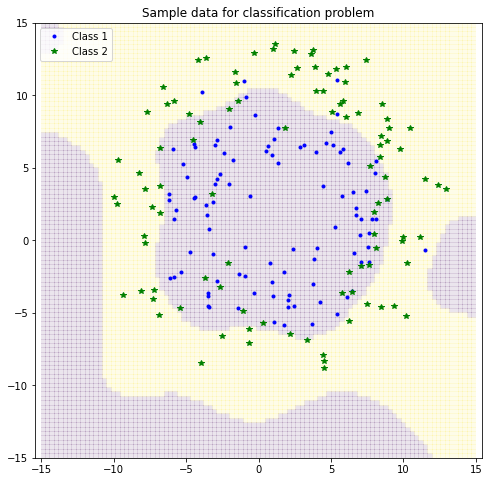

In [35]:
#hyperparameter
s = [0.5,1,2,3] #RBF parameter, greater the value less curvature
cc = [0.01, 0.1, 1, 10]   #higher c -> more training error
for sigma in s:
    for c in cc:
        K_annulus = gausskernel(X_annulus, sigma)
        print("K_annulus shape", K_annulus.shape)
        Q_annulus, C, A, B, E, d = quadparams(X_annulus, y_annulus, K_annulus, c)

        alpha_star_annulus = cvxopt_solve_qp(Q_annulus, C, A, B, E, d)

        y_pred = predict(X_annulus, X_annulus, y_annulus, alpha_star_annulus, sigma)
        accuracy = np.sum(y_annulus == y_pred)/y_annulus.size
        print(f"Accuracy is for c={c} and sigma={sigma} is: {accuracy}")

        #plot
        x_series = np.linspace(-15, 15, 100)
        y_series = np.linspace(-15, 15, 100)

        x_mesh, y_mesh = np.meshgrid(x_series, y_series)

        x_mesh = x_mesh.reshape(-1, 1)
        y_mesh = y_mesh.reshape(-1, 1)

        mesh = np.append(x_mesh, y_mesh, axis=1)
        y_pred = predict(mesh, X_annulus, y_annulus, alpha_star_annulus, sigma)

        x_mesh = x_mesh.reshape(100, 100)
        y_mesh = y_mesh.reshape(100, 100)
        y_pred = y_pred.reshape(100, 100)

        fig1 = plt.figure(figsize=(8,8))
        ax = plot_annulus(X1, X2)
        ax.pcolormesh(x_mesh, y_mesh, y_pred, cmap='viridis', shading='auto', alpha=0.1)
        plt.show()

### Discussions

**About datasets**

In the above example, I created the dataset by using the previous annulus method, where I set the mean and standard deviation of the two classes close to each other. This helped to create the needed overlapping of datasets of two classes. So, in this way, we get the dataset that are not separable and that needs non-linear decision boundary.

**Hyperparameters**

I chose Radial Basis Function (RBF or Gaussian) as a Kernel function, which contains sigma parameter. This sigma parameter of that kernel function is one of the hyperparameters of our SVM.

Since our datasets are non-separable, in order for our SVM to works on such type of datasets we needed to introduce slack variable to the optimization probability function. The purpose of this slack variable is to let our margins to intrude into the other class. To control this amount we introduce another parameter (hyperparameter) 'c' in the optimization function. At last when we solved this function using Dual Lagrangian Optimization we get the equation that similar to Linearly Separable Condition, surprisingly these resulting equations are independent of the slack varible, except this equation, which is a function of hyperparameter 'c': $$ 0 \le \alpha_i \le c $$

**Finding better Hyperparameters**

I used the training datasets accuracy and the boundary plot of the model in order to determine best hyperparameters for our model. We can use validation datasets to do that, but here I am using the decision boundary plot in order to find the better hyperparamters.
The combination of hyperparameters that I found to be best are listed below: (below accuracy is training accuracy)

a. Accuracy is for c=0.1 and sigma=3 is: 0.81

b. Accuracy is for c=0.01 and sigma=3 is: 0.805

c. Accuracy for c=0.1 and sigma=2 is: 0.825

d. Accuracy is for c=0.01 and sigma=2 is: 0.825


**Effect of hyperparmeters c and sigma in decision boundary**

We can see from the above plot that larger value of sigma gave us a smooth decision boundary (seems like lower order decision boundary), while smaller value of sigma gave us curvy decision boundary (seems like higher order decision boundary).

The effect of 'c' is - smaller value of c gave us decision boundary with less compact margin while larger value of c gave us decision boundary with more compact margin trying to minimize the training error to the most.

We get the worst decision boundary with these combinations of c and sigma hyperparameters: (below accuracy is the training accuracy)

- Accuracy is for c=10 and sigma=3 is: 0.835

- Accuracy is for c=10 and sigma=2 is: 0.865

- Accuracy is for c=10 and sigma=1 is: 0.94

- Accuracy is for c=10 and sigma=0.5 is: 0.99 (worst of all)

- Accuracy is for c=1 and sigma=0.5 is: 0.97

As we can see the model with hyperparameters c = 10 and sigma = 0.5 has the worst decision boundary which tries to minimize the training error to the most. These c and sigma values are the highest and smallest of the provided values for grid search respectively.


In [39]:
import random
random.seed(0)

idx = np.arange(0,X_annulus.shape[0],1)
np.random.shuffle(idx)
train_size = int(X_annulus.shape[0] * 0.8)
# print(train_size)

train_idx = idx[:train_size]
test_idx = idx[train_size:]

X_train = X_annulus[train_idx]
X_test = X_annulus[test_idx]
y_train = y_annulus[train_idx]
y_test = y_annulus[test_idx]



In [40]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(160, 2)
(160, 1)
(40, 2)
(40, 1)


     pcost       dcost       gap    pres   dres
 0: -6.1053e+01 -2.0902e+01  1e+02  3e+01  2e-16
 1: -4.1186e+01 -8.6393e+00  4e+00  4e+00  1e-16
 2: -2.3982e+00 -1.5831e+00  1e+00  2e-01  1e-15
 3: -1.6033e+00 -1.5755e+00  6e-02  7e-03  2e-16
 4: -1.5310e+00 -1.5330e+00  4e-03  1e-04  1e-15
 5: -1.5325e+00 -1.5326e+00  2e-04  8e-06  3e-16
 6: -1.5326e+00 -1.5326e+00  6e-06  4e-08  2e-16
 7: -1.5326e+00 -1.5326e+00  6e-08  4e-10  3e-16
Optimal solution found.
Accuracy is for c=0.01 and sigma=0.1 is: 0.675


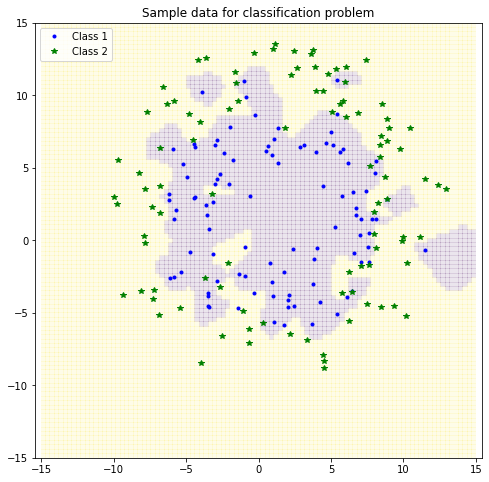

     pcost       dcost       gap    pres   dres
 0: -6.4542e+01 -3.1089e+01  1e+02  2e+01  2e-16
 1: -4.9203e+01 -2.1577e+01  3e+00  3e+00  1e-16
 2: -1.7649e+01 -1.5013e+01  2e+00  3e-01  1e-15
 3: -1.5054e+01 -1.4820e+01  2e-01  3e-02  6e-16
 4: -1.4666e+01 -1.4660e+01  7e-03  9e-04  2e-15
 5: -1.4656e+01 -1.4656e+01  2e-04  1e-06  1e-15
 6: -1.4656e+01 -1.4656e+01  2e-06  1e-08  3e-16
Optimal solution found.
Accuracy is for c=0.1 and sigma=0.1 is: 0.675


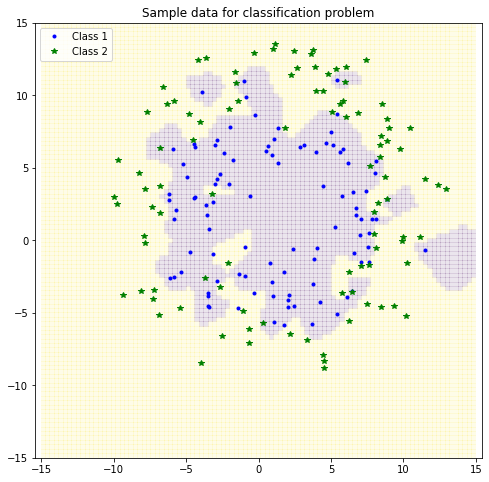

     pcost       dcost       gap    pres   dres
 0: -8.1870e+01 -7.8663e+01  4e+02  2e+00  1e+00
 1: -5.1600e+01 -1.0868e+02  6e+01  4e-15  2e-16
 2: -7.5870e+01 -8.4205e+01  8e+00  4e-15  1e-16
 3: -7.9350e+01 -8.0480e+01  1e+00  7e-17  8e-17
 4: -7.9832e+01 -7.9935e+01  1e-01  9e-16  5e-17
 5: -7.9879e+01 -7.9881e+01  2e-03  9e-16  6e-17
 6: -7.9880e+01 -7.9880e+01  3e-05  5e-17  7e-17
Optimal solution found.
Accuracy is for c=1 and sigma=0.1 is: 0.675


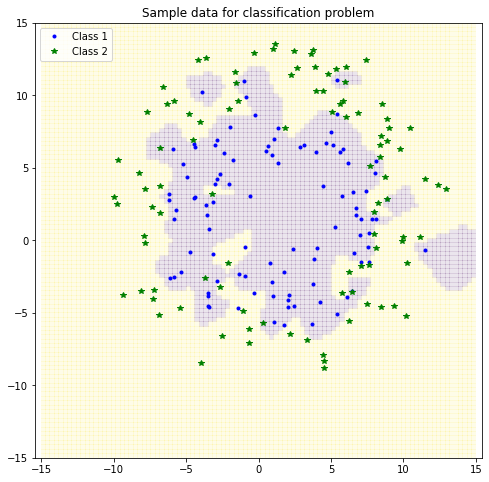

     pcost       dcost       gap    pres   dres
 0:  1.5010e+03 -1.5431e+02  2e+03  2e-01  7e+00
 1: -9.1807e+01 -1.6539e+02  7e+01  8e-03  3e-01
 2: -9.6664e+01 -9.7515e+01  9e-01  8e-05  3e-03
 3: -9.6769e+01 -9.6782e+01  1e-02  1e-06  4e-05
 4: -9.6771e+01 -9.6771e+01  1e-04  1e-08  4e-07
 5: -9.6771e+01 -9.6771e+01  1e-06  1e-10  4e-09
Optimal solution found.
Accuracy is for c=10 and sigma=0.1 is: 0.675


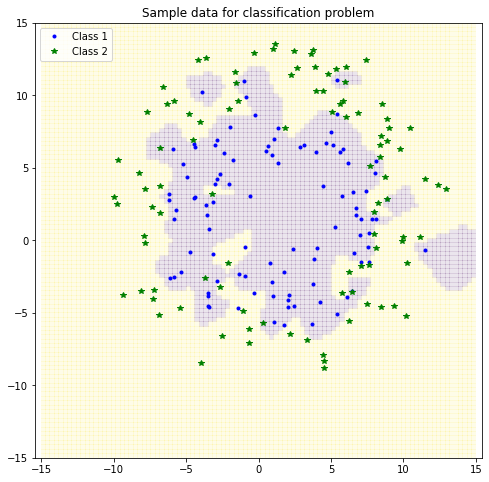

     pcost       dcost       gap    pres   dres
 0: -5.8257e+01 -1.5663e+01  1e+02  3e+01  3e-16
 1: -3.2248e+01 -1.0687e+01  2e+01  7e+00  2e-16
 2: -1.7722e+01 -4.3471e+00  1e+01  3e+00  3e-16
 3: -2.2600e+00 -1.5905e+00  6e+00  5e-01  4e-16
 4: -1.5911e+00 -1.5778e+00  1e-01  1e-02  5e-16
 5: -1.5385e+00 -1.5409e+00  2e-02  1e-03  4e-16
 6: -1.5272e+00 -1.5274e+00  2e-03  1e-04  2e-15
 7: -1.5263e+00 -1.5275e+00  1e-03  3e-06  2e-15
 8: -1.5267e+00 -1.5269e+00  3e-04  6e-07  5e-16
 9: -1.5268e+00 -1.5268e+00  8e-05  5e-09  3e-16
10: -1.5268e+00 -1.5268e+00  8e-06  3e-10  3e-16
11: -1.5268e+00 -1.5268e+00  3e-07  8e-12  3e-16
Optimal solution found.
Accuracy is for c=0.01 and sigma=1 is: 0.775


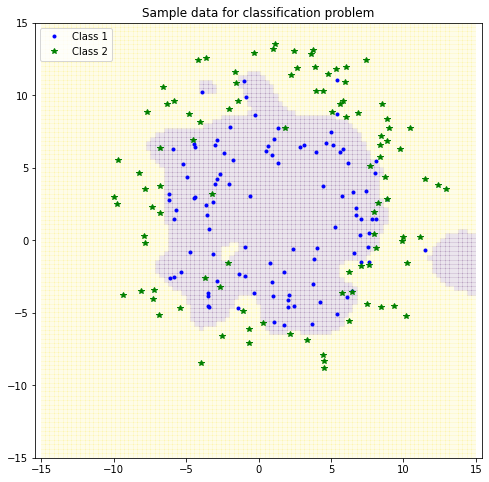

     pcost       dcost       gap    pres   dres
 0: -6.1997e+01  3.9995e+01  4e+02  2e+01  1e+00
 1:  1.3293e+01 -1.7361e+01  3e+01  3e-15  6e-16
 2: -1.1338e+01 -1.4541e+01  3e+00  1e-15  4e-16
 3: -1.3910e+01 -1.4329e+01  4e-01  4e-16  3e-16
 4: -1.3967e+01 -1.4130e+01  2e-01  1e-16  2e-16
 5: -1.3988e+01 -1.4136e+01  1e-01  7e-17  3e-16
 6: -1.4047e+01 -1.4092e+01  4e-02  2e-16  3e-16
 7: -1.4072e+01 -1.4084e+01  1e-02  3e-16  3e-16
 8: -1.4081e+01 -1.4082e+01  1e-03  8e-17  3e-16
 9: -1.4082e+01 -1.4082e+01  1e-04  1e-16  3e-16
10: -1.4082e+01 -1.4082e+01  2e-06  1e-16  3e-16
Optimal solution found.
Accuracy is for c=0.1 and sigma=1 is: 0.775


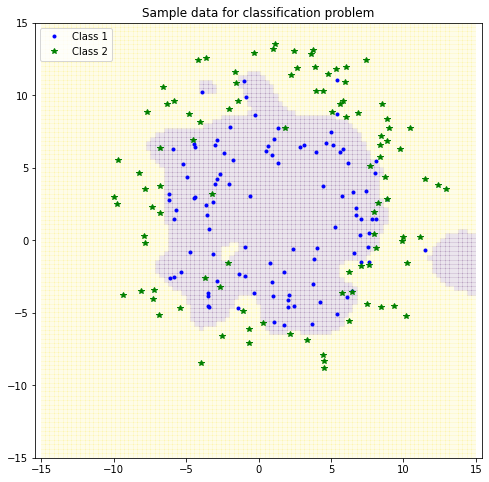

     pcost       dcost       gap    pres   dres
 0: -8.6348e+01 -7.1077e+01  7e+02  3e+00  2e+00
 1: -2.3334e+01 -1.2722e+02  1e+02  4e-16  8e-16
 2: -6.0812e+01 -7.5727e+01  1e+01  1e-15  3e-16
 3: -6.5912e+01 -6.8818e+01  3e+00  2e-15  2e-16
 4: -6.7013e+01 -6.7417e+01  4e-01  9e-16  2e-16
 5: -6.7170e+01 -6.7219e+01  5e-02  1e-16  3e-16
 6: -6.7191e+01 -6.7195e+01  4e-03  9e-16  2e-16
 7: -6.7193e+01 -6.7193e+01  1e-04  3e-15  3e-16
 8: -6.7193e+01 -6.7193e+01  7e-06  1e-15  2e-16
Optimal solution found.
Accuracy is for c=1 and sigma=1 is: 0.8


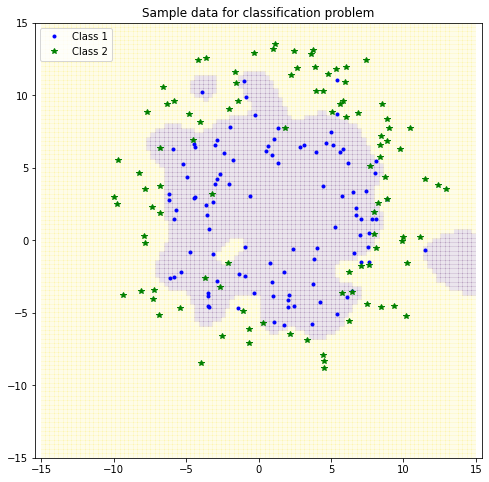

     pcost       dcost       gap    pres   dres
 0:  9.7572e+02 -1.8196e+03  7e+03  5e-01  1e+01
 1: -1.7026e+02 -6.4719e+02  5e+02  2e-02  3e-01
 2: -2.1223e+02 -2.8560e+02  7e+01  2e-03  3e-02
 3: -2.2316e+02 -2.3372e+02  1e+01  2e-04  4e-03
 4: -2.2502e+02 -2.2568e+02  7e-01  3e-06  6e-05
 5: -2.2512e+02 -2.2514e+02  2e-02  6e-08  1e-06
 6: -2.2513e+02 -2.2513e+02  4e-04  6e-10  1e-08
 7: -2.2513e+02 -2.2513e+02  4e-06  6e-12  1e-10
Optimal solution found.
Accuracy is for c=10 and sigma=1 is: 0.65


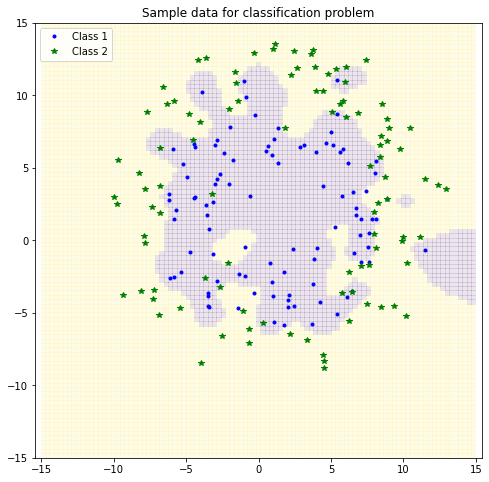

     pcost       dcost       gap    pres   dres
 0: -6.7626e+01  6.6528e+01  5e+02  3e+01  1e+00
 1:  2.4297e+01 -3.2868e+00  5e+01  1e+00  4e-02
 2:  9.8904e-01 -1.6248e+00  4e+00  9e-02  3e-03
 3: -1.4750e+00 -1.5712e+00  1e-01  2e-03  7e-05
 4: -1.5163e+00 -1.5309e+00  2e-02  3e-04  8e-06
 5: -1.5158e+00 -1.5188e+00  4e-03  6e-05  2e-06
 6: -1.5162e+00 -1.5194e+00  4e-03  3e-05  1e-06
 7: -1.5169e+00 -1.5181e+00  1e-03  1e-05  3e-07
 8: -1.5171e+00 -1.5179e+00  8e-04  5e-07  1e-08
 9: -1.5176e+00 -1.5177e+00  1e-04  7e-08  2e-09
10: -1.5177e+00 -1.5177e+00  5e-05  1e-17  4e-16
11: -1.5177e+00 -1.5177e+00  2e-06  1e-17  4e-16
12: -1.5177e+00 -1.5177e+00  2e-08  4e-17  4e-16
Optimal solution found.
Accuracy is for c=0.01 and sigma=2 is: 0.75


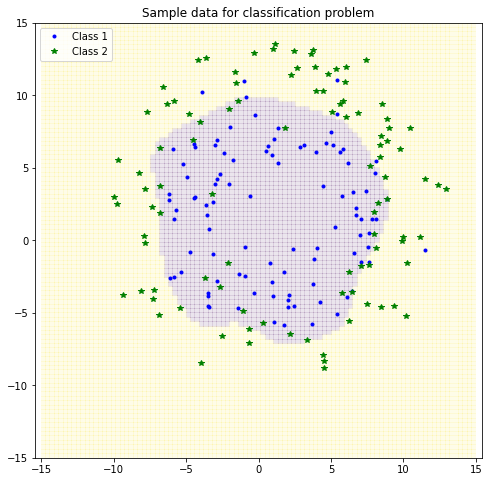

     pcost       dcost       gap    pres   dres
 0: -7.2774e+01  5.7265e+01  5e+02  3e+01  1e+00
 1:  2.3887e+01 -1.8173e+01  5e+01  2e-01  9e-03
 2: -7.7359e+00 -1.4022e+01  7e+00  2e-02  9e-04
 3: -1.2742e+01 -1.3324e+01  6e-01  9e-04  3e-05
 4: -1.2979e+01 -1.3206e+01  2e-01  3e-04  1e-05
 5: -1.3070e+01 -1.3190e+01  1e-01  1e-05  6e-07
 6: -1.3163e+01 -1.3173e+01  1e-02  5e-07  2e-08
 7: -1.3171e+01 -1.3172e+01  1e-03  4e-08  2e-09
 8: -1.3172e+01 -1.3172e+01  1e-05  4e-10  2e-11
Optimal solution found.
Accuracy is for c=0.1 and sigma=2 is: 0.75


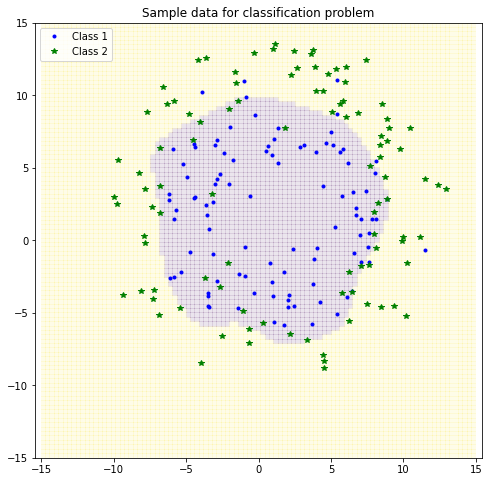

     pcost       dcost       gap    pres   dres
 0: -1.1634e+02 -4.3766e+01  1e+03  3e+00  2e+00
 1: -1.6865e+00 -1.4406e+02  1e+02  3e-15  1e-15
 2: -5.5331e+01 -8.1753e+01  3e+01  2e-16  5e-16
 3: -6.6590e+01 -7.2056e+01  5e+00  9e-16  4e-16
 4: -6.8952e+01 -7.0067e+01  1e+00  3e-15  5e-16
 5: -6.9537e+01 -6.9653e+01  1e-01  2e-15  5e-16
 6: -6.9600e+01 -6.9608e+01  8e-03  7e-16  5e-16
 7: -6.9604e+01 -6.9604e+01  3e-04  1e-15  6e-16
 8: -6.9604e+01 -6.9604e+01  9e-06  2e-15  6e-16
Optimal solution found.
Accuracy is for c=1 and sigma=2 is: 0.8


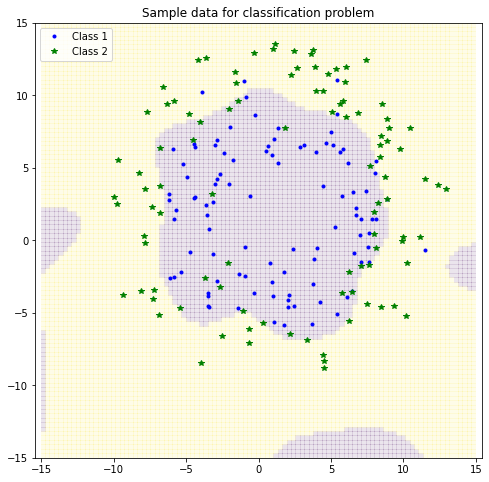

     pcost       dcost       gap    pres   dres
 0:  2.3865e+02 -1.8944e+03  1e+04  1e+00  1e+01
 1: -1.6033e+02 -1.4166e+03  1e+03  2e-02  2e-01
 2: -3.5018e+02 -7.8570e+02  4e+02  5e-03  6e-02
 3: -4.4448e+02 -5.8096e+02  1e+02  5e-15  3e-15
 4: -4.8930e+02 -5.1266e+02  2e+01  1e-14  3e-15
 5: -4.9836e+02 -5.0177e+02  3e+00  2e-15  4e-15
 6: -4.9984e+02 -5.0013e+02  3e-01  3e-14  4e-15
 7: -4.9998e+02 -4.9999e+02  6e-03  3e-14  4e-15
 8: -4.9999e+02 -4.9999e+02  9e-05  2e-14  4e-15
Optimal solution found.
Accuracy is for c=10 and sigma=2 is: 0.8


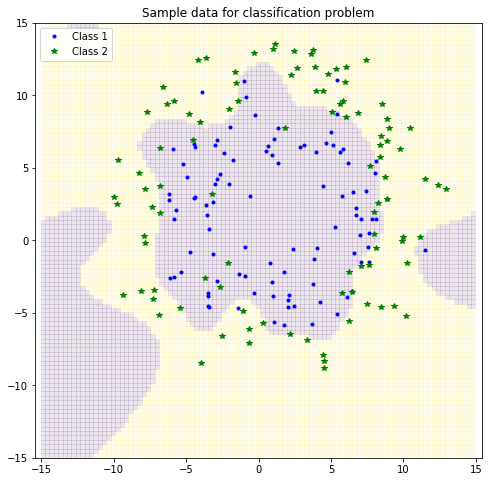

     pcost       dcost       gap    pres   dres
 0: -7.5473e+01  8.9631e+01  6e+02  4e+01  1e+00
 1:  3.5855e+01 -5.3785e+00  8e+01  2e+00  7e-02
 2:  4.0729e+00 -1.8426e+00  9e+00  2e-01  8e-03
 3: -1.1626e+00 -1.5693e+00  5e-01  6e-03  2e-04
 4: -1.5091e+00 -1.5530e+00  5e-02  6e-04  2e-05
 5: -1.5059e+00 -1.5131e+00  8e-03  7e-05  2e-06
 6: -1.5091e+00 -1.5135e+00  5e-03  1e-05  4e-07
 7: -1.5110e+00 -1.5120e+00  1e-03  2e-06  8e-08
 8: -1.5113e+00 -1.5119e+00  6e-04  7e-07  2e-08
 9: -1.5117e+00 -1.5118e+00  9e-05  9e-08  3e-09
10: -1.5118e+00 -1.5118e+00  6e-06  4e-09  1e-10
11: -1.5118e+00 -1.5118e+00  6e-08  4e-11  1e-12
Optimal solution found.
Accuracy is for c=0.01 and sigma=3 is: 0.775


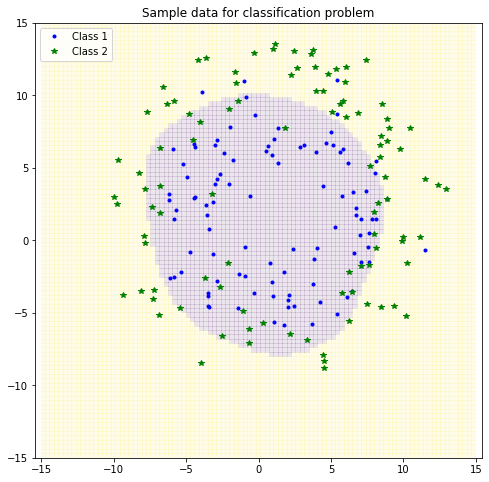

     pcost       dcost       gap    pres   dres
 0: -8.1572e+01  8.1217e+01  7e+02  3e+01  1e+00
 1:  3.5965e+01 -2.1791e+01  8e+01  1e+00  5e-02
 2: -3.5325e+00 -1.4916e+01  1e+01  1e-01  6e-03
 3: -1.1382e+01 -1.2907e+01  2e+00  4e-03  2e-04
 4: -1.2383e+01 -1.2604e+01  2e-01  4e-04  2e-05
 5: -1.2466e+01 -1.2588e+01  1e-01  1e-04  7e-06
 6: -1.2556e+01 -1.2577e+01  2e-02  2e-05  8e-07
 7: -1.2575e+01 -1.2576e+01  2e-03  2e-16  3e-16
 8: -1.2576e+01 -1.2576e+01  2e-05  8e-17  3e-16
 9: -1.2576e+01 -1.2576e+01  2e-07  3e-16  3e-16
Optimal solution found.
Accuracy is for c=0.1 and sigma=3 is: 0.775


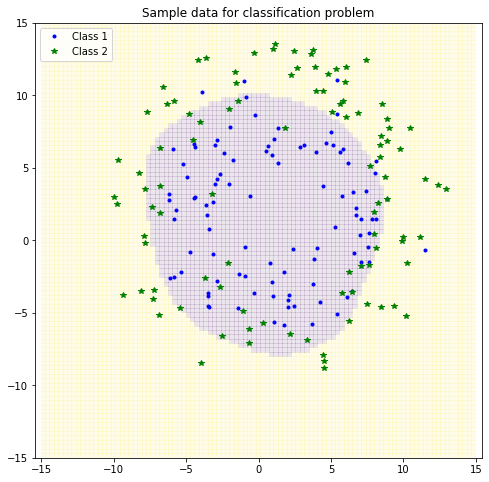

     pcost       dcost       gap    pres   dres
 0: -1.3691e+02 -2.2215e+01  1e+03  4e+00  2e+00
 1:  2.0710e+01 -1.6797e+02  2e+02  5e-15  2e-15
 2: -4.4962e+01 -9.3125e+01  5e+01  4e-15  7e-16
 3: -7.0156e+01 -8.0948e+01  1e+01  1e-16  6e-16
 4: -7.5843e+01 -7.8284e+01  2e+00  3e-15  8e-16
 5: -7.7327e+01 -7.7669e+01  3e-01  3e-15  9e-16
 6: -7.7548e+01 -7.7591e+01  4e-02  1e-15  1e-15
 7: -7.7578e+01 -7.7581e+01  3e-03  1e-15  9e-16
 8: -7.7580e+01 -7.7580e+01  1e-04  1e-15  9e-16
 9: -7.7580e+01 -7.7580e+01  2e-06  1e-15  9e-16
Optimal solution found.
Accuracy is for c=1 and sigma=3 is: 0.8


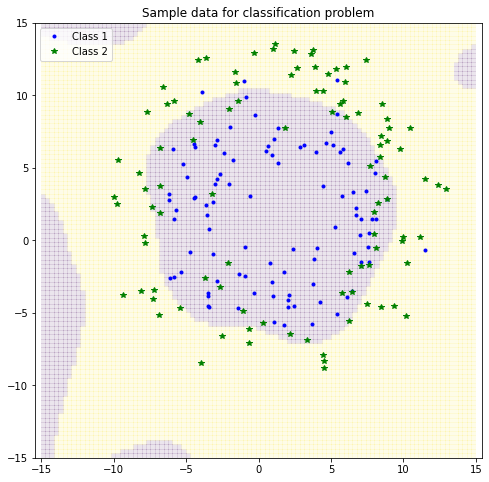

     pcost       dcost       gap    pres   dres
 0: -1.2613e+02 -2.9857e+03  2e+04  1e+00  1e+01
 1: -9.7052e+01 -2.2895e+03  2e+03  3e-02  3e-01
 2: -3.4974e+02 -9.2786e+02  6e+02  1e-03  1e-02
 3: -5.2779e+02 -6.9479e+02  2e+02  2e-04  3e-03
 4: -5.9458e+02 -6.3515e+02  4e+01  7e-08  8e-07
 5: -6.1123e+02 -6.1937e+02  8e+00  1e-08  1e-07
 6: -6.1512e+02 -6.1663e+02  2e+00  9e-10  1e-08
 7: -6.1589e+02 -6.1612e+02  2e-01  1e-10  2e-09
 8: -6.1602e+02 -6.1603e+02  1e-02  3e-12  4e-11
 9: -6.1603e+02 -6.1603e+02  4e-04  1e-13  7e-13
Optimal solution found.
Accuracy is for c=10 and sigma=3 is: 0.8


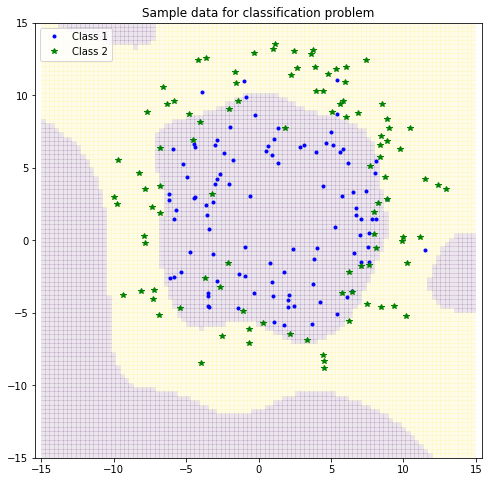

In [44]:
#hyperparameter
s = [0.1, 1, 2, 3] #RBF parameter, greater the value less curvature
cc = [0.01, 0.1, 1, 10]   #higher c -> more training error
for sigma in s:
    for c in cc:
        K_train = gausskernel(X_train, sigma)
        Q_train, C, A, B, E, d = quadparams(X_train, y_train, K_train, c)

        alpha_star_train = cvxopt_solve_qp(Q_train, C, A, B, E, d)

        y_pred = predict(X_test, X_train, y_train, alpha_star_train, sigma)
        accuracy = np.sum(y_test == y_pred)/y_test.size
        print(f"Accuracy is for c={c} and sigma={sigma} is: {accuracy}")

        #plot
        x_series = np.linspace(-15, 15, 100)
        y_series = np.linspace(-15, 15, 100)

        x_mesh, y_mesh = np.meshgrid(x_series, y_series)

        x_mesh = x_mesh.reshape(-1, 1)
        y_mesh = y_mesh.reshape(-1, 1)

        mesh = np.append(x_mesh, y_mesh, axis=1)
        y_pred = predict(mesh, X_train, y_train, alpha_star_train, sigma)

        x_mesh = x_mesh.reshape(100, 100)
        y_mesh = y_mesh.reshape(100, 100)
        y_pred = y_pred.reshape(100, 100)

        fig1 = plt.figure(figsize=(8,8))
        ax = plot_annulus(X1, X2)
        ax.pcolormesh(x_mesh, y_mesh, y_pred, cmap='viridis', shading='auto', alpha=0.1)
        plt.show()

### Results using validation sets

The highest accuracy that I got on unseen validation set is 0.8. The combinations of c and sigma that helped to achieve this level of accuracy are:

- c=10 and sigma=3
- c=1 and sigma=3
- c=10 and sigma=2
- c=1 and sigma=2
- c=1 and sigma=1